# Importing all the necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\RAJAN SHRIVASTAVA\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 3.Reading the Data

# Reading Gene and Variation Data

In [2]:
data=pd.read_csv('training_variants')
print('Number of the Data points : ',data.shape[0])
print('Number of the Features : ',data.shape[1])
print('Features :',data.columns.values)
data.head()

Number of the Data points :  3321
Number of the Features :  4
Features : ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

# Reading the Text Data

In [3]:
text_data=pd.read_csv('training_text',sep='\|\|',names=['ID','TEXT'],engine='python',skiprows=1)
print('Number of data points : ', text_data.shape[0])
print('Number of features : ', text_data.shape[1])
print('Features : ', text_data.columns.values)
text_data.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

# Data preprocessing 

In [5]:
stop_words=set(stopwords.words('english'))
def text_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        # replace every special char with space
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',str(total_text))
        #Repalce multiple space with single space
        total_text=re.sub('\s+',' ',total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        text_data[column][index] = string       

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in text_data.iterrows():
    text_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 367.3702651841038 seconds


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data,text_data,on='ID', how='left')
result.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

# Train , Cv and Test Split

# Splitting the data into (60:20:20)

In [8]:
y_true=result['Class'].values
result.Variation = result.Variation.str.replace('\s+', '_')
result.Gene=result.Gene.str.replace('\s+','_')
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [9]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


# Check the distribution of the y's in Train ,Test and CV 

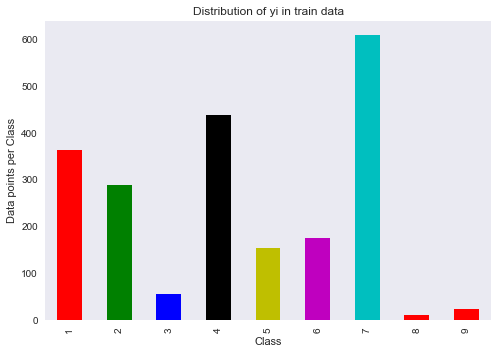

Number of the Data points in the class 7 : 609 ( 28.672 %)
Number of the Data points in the class 4 : 439 ( 20.669 %)
Number of the Data points in the class 1 : 363 ( 17.09 %)
Number of the Data points in the class 2 : 289 ( 13.606 %)
Number of the Data points in the class 6 : 176 ( 8.286 %)
Number of the Data points in the class 5 : 155 ( 7.298 %)
Number of the Data points in the class 3 : 57 ( 2.684 %)
Number of the Data points in the class 9 : 24 ( 1.13 %)
Number of the Data points in the class 8 : 12 ( 0.565 %)


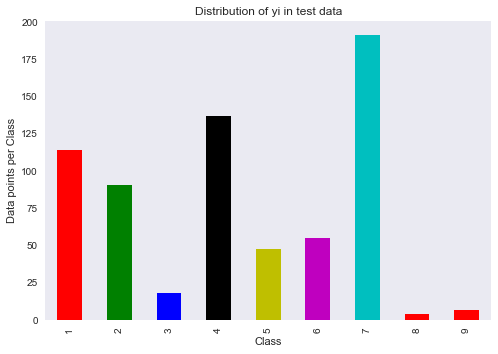

Number of the Data points in the class 7 : 191 ( 28.722 %)
Number of the Data points in the class 4 : 137 ( 20.602 %)
Number of the Data points in the class 1 : 114 ( 17.143 %)
Number of the Data points in the class 2 : 91 ( 13.684 %)
Number of the Data points in the class 6 : 55 ( 8.271 %)
Number of the Data points in the class 5 : 48 ( 7.218 %)
Number of the Data points in the class 3 : 18 ( 2.707 %)
Number of the Data points in the class 9 : 7 ( 1.053 %)
Number of the Data points in the class 8 : 4 ( 0.602 %)


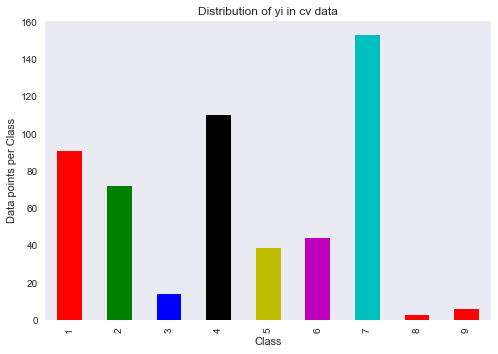

Number of the Data points in the class 7 : 153 ( 28.759 %)
Number of the Data points in the class 4 : 110 ( 20.677 %)
Number of the Data points in the class 1 : 91 ( 17.105 %)
Number of the Data points in the class 2 : 72 ( 13.534 %)
Number of the Data points in the class 6 : 44 ( 8.271 %)
Number of the Data points in the class 5 : 39 ( 7.331 %)
Number of the Data points in the class 3 : 14 ( 2.632 %)
Number of the Data points in the class 9 : 6 ( 1.128 %)
Number of the Data points in the class 8 : 3 ( 0.564 %)


In [40]:
train_class_distribution=train_df['Class'].value_counts().sortlevel()
test_class_distribution=test_df['Class'].value_counts().sortlevel()
cv_class_distribution=cv_df['Class'].value_counts().sortlevel()

my_colors =['r', 'g', 'b', 'k', 'y', 'm', 'c'] 
train_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi=np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of the Data points in the class',i+1,':',train_class_distribution.values[i],'(',np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

test_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi=np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of the Data points in the class',i+1,':',test_class_distribution.values[i],'(',np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
    
    
cv_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()
sorted_yi=np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of the Data points in the class',i+1,':',cv_class_distribution.values[i],'(',np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')
        

# Predicting using Random Model

In [14]:
def plot_confusion_matrix(test_y,predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()        

Log loss on Cross Validation Data using Random Model 2.5183771013216534
Log loss on Test Data using Random Model 2.480349360039722
-------------------- Confusion matrix --------------------


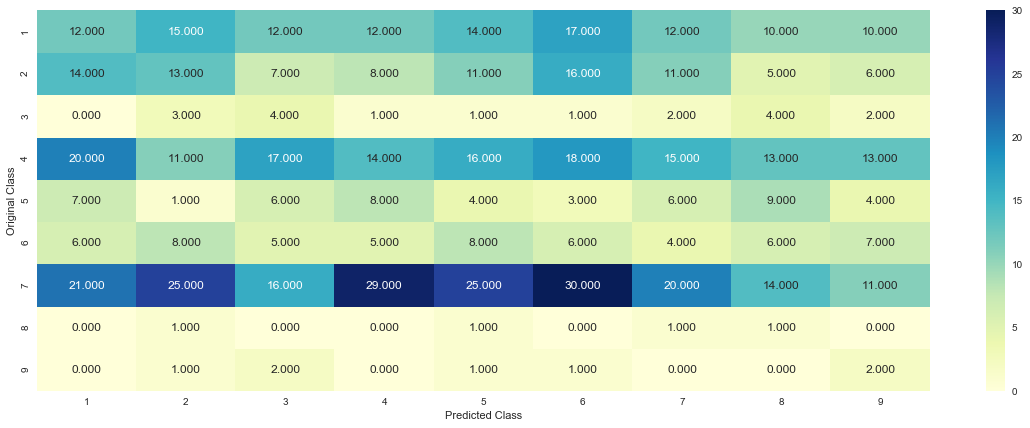

-------------------- Precision matrix (Columm Sum=1) --------------------


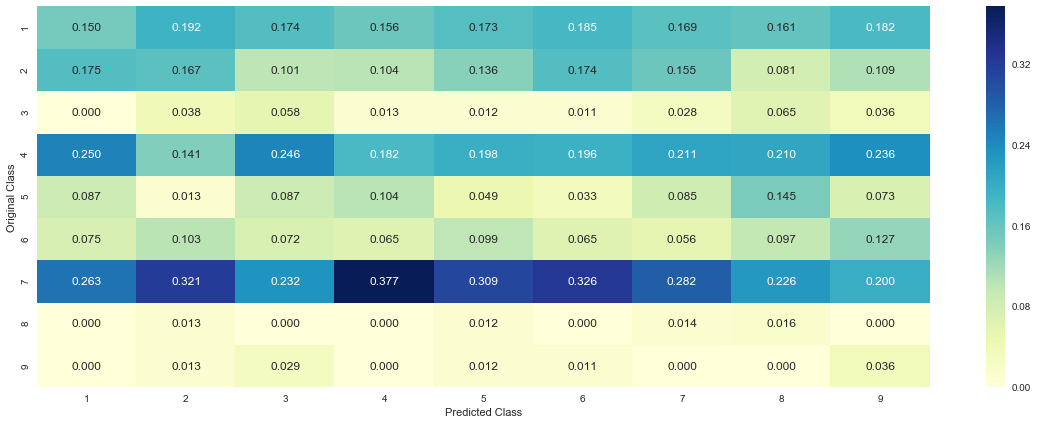

-------------------- Recall matrix (Row sum=1) --------------------


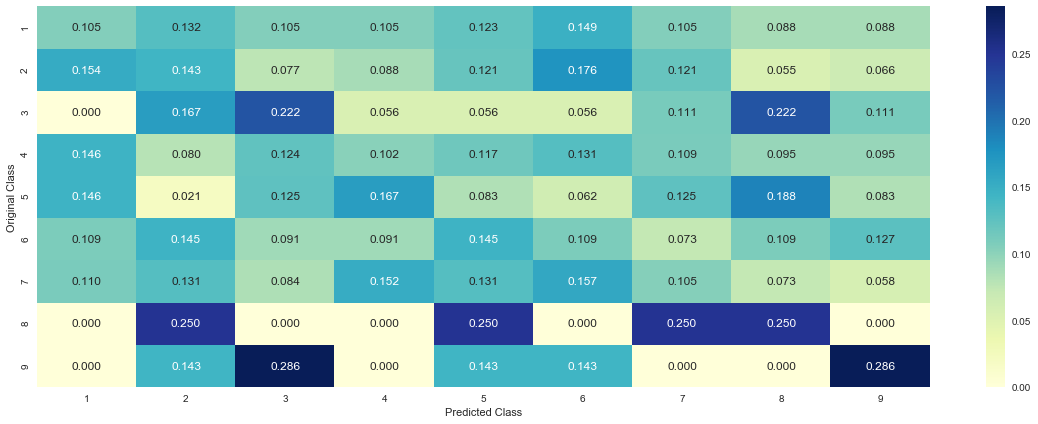

In [16]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# Univariate Analysis

In [17]:
def get_gv_fea_dict(aplha,feature,df):
    value_count=train_df[feature].value_counts()
    gv_dict=dict()
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

# Univariate analysis of the Gene Feature

In [18]:
unique_genes=train_df['Gene'].value_counts()
print('Number of Unique Genes :',unique_genes.shape[0])
print('Top ten genes that occured most :',unique_genes.head(10))

Number of Unique Genes : 240
Top ten genes that occured most : BRCA1     181
TP53      100
EGFR       87
PTEN       78
BRCA2      75
KIT        58
BRAF       56
PDGFRA     44
ERBB2      43
ALK        37
Name: Gene, dtype: int64


In [19]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 240 different categories of genes in the train data, and they are distibuted as follows


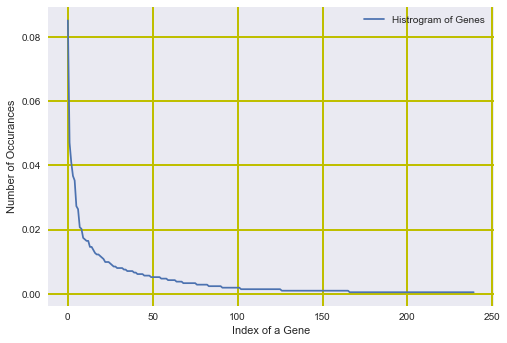

In [20]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid(color='y', linestyle='-', linewidth=2)
plt.show()

# c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid(color='y', linestyle='-', linewidth=2)
plt.legend()
plt.show()

# Featurize the Gene feature

# Using Response coding 

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [22]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [23]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [24]:
train_df['Gene'].head()

240       EGFR
100     TGFBR2
3279       RET
1644      FLT3
1896      MTOR
Name: Gene, dtype: object

In [25]:
gene_vectorizer.get_feature_names()

['abl1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla'

In [26]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 239)


# How good is this gene feature in predicting y_i?

For values of alpha =  1e-05 The log loss is: 1.3567702505187953
For values of alpha =  0.0001 The log loss is: 1.1823926768822028
For values of alpha =  0.001 The log loss is: 1.1810561233727572
For values of alpha =  0.01 The log loss is: 1.2790241502402926
For values of alpha =  0.1 The log loss is: 1.3996350960455908
For values of alpha =  1 The log loss is: 1.4486111744692278


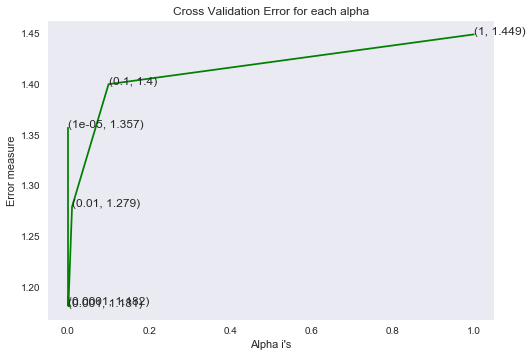

For values of best alpha =  0.001 The train log loss is: 1.1049476467845
For values of best alpha =  0.001 The cross validation log loss is: 1.1810561233727572
For values of best alpha =  0.001 The test log loss is: 1.2319821568281588


In [27]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# <p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [28]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  240  genes in train dataset?
Ans
1. In test data 650 out of 665 : 97.74436090225564
2. In cross validation data 518 out of  532 : 97.36842105263158


# <p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [29]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1926
Truncating_Mutations    58
Deletion                48
Amplification           48
Fusions                 22
Overexpression           3
V321M                    2
T167A                    2
A146V                    2
G12V                     2
G12D                     2
Name: Variation, dtype: int64


In [30]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1926 different categories of variations in the train data, and they are distibuted as follows


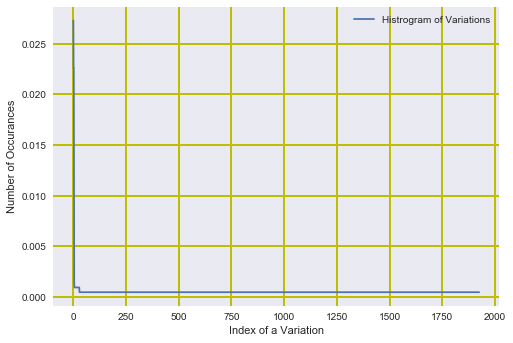

In [31]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid(color='y', linestyle='-', linewidth=2)
plt.show()

[0.02730697 0.04990584 0.07250471 ... 0.99905838 0.99952919 1.        ]


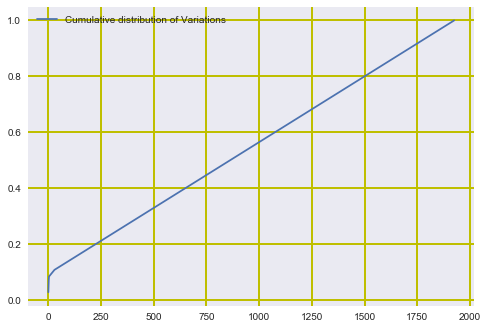

In [32]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid(color='y', linestyle='-', linewidth=2)
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [33]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [34]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [35]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [36]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1953)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

For values of alpha =  1e-05 The log loss is: 1.7447468527392471
For values of alpha =  0.0001 The log loss is: 1.734307695787659
For values of alpha =  0.001 The log loss is: 1.7351405878563373
For values of alpha =  0.01 The log loss is: 1.7380714058045028
For values of alpha =  0.1 The log loss is: 1.7441885361435367
For values of alpha =  1 The log loss is: 1.7463242231437959


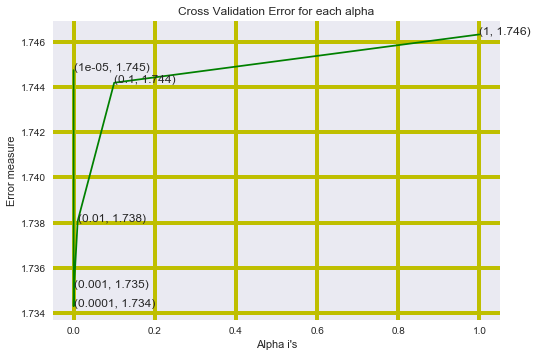

For values of best alpha =  0.0001 The train log loss is: 0.7732449445422113
For values of best alpha =  0.0001 The cross validation log loss is: 1.734307695787659
For values of best alpha =  0.0001 The test log loss is: 1.70080879725203


In [37]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='y', linestyle='-', linewidth=4)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [38]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1926  genes in test and cross validation data sets?
Ans
1. In test data 73 out of 665 : 10.977443609022556
2. In cross validation data 50 out of  532 : 9.398496240601503


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

# 1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [41]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [42]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [43]:
text_vectorizer=TfidfVectorizer(min_df=3)
train_text_feature_onehotCoding=text_vectorizer.fit_transform(train_df['TEXT'])

In [44]:
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()


# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53176


In [45]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [46]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [47]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [48]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [49]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [50]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.006672197235706023: 402, 0.012706451777141635: 316, 0.0459520407374555: 232, 0.05631101190014791: 198, 0.021920810732671187: 156, 0.2881122275321722: 154, 0.026581403294313383: 141, 0.25760271631934467: 126, 0.05886720431706007: 125, 0.041939747120126755: 114, 0.0575070368769173: 109, 0.009399112453836355: 109, 0.09020999367725567: 104, 0.03942576954035273: 103, 0.058013994823840315: 101, 0.03594069443352238: 94, 0.02669158050797487: 93, 0.024278577876512192: 89, 0.011972494648492971: 88, 0.01963907883029809: 86, 0.11042757842408456: 85, 0.015135644364521736: 85, 0.03460475731817486: 80, 0.017427412372634666: 79, 0.04268746035219861: 78, 0.015412337804063623: 76, 0.00875721998054603: 76, 0.05258017274611298: 73, 0.0271615919127831: 67, 0.055074372629469806: 66, 0.08070525965722164: 65, 0.037302350925493444: 65, 0.025216966112582687: 64, 0.017697549145685873: 64, 0.015148811291824164: 63, 0.011753584054592882: 63, 0.026618406750605166: 60, 0.01362312429299756: 60, 0.013337280

For values of alpha =  1e-05 The log loss is: 1.2770694887356695
For values of alpha =  0.0001 The log loss is: 1.2298026202680645
For values of alpha =  0.001 The log loss is: 1.1112481288899398
For values of alpha =  0.01 The log loss is: 1.1960079438944629
For values of alpha =  0.1 The log loss is: 1.3027633599336501
For values of alpha =  1 The log loss is: 1.5014811007200501


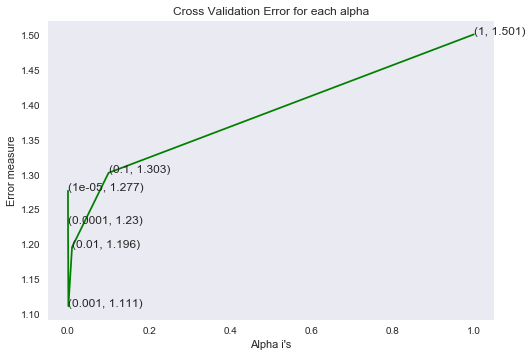

For values of best alpha =  0.001 The train log loss is: 0.663301289576225
For values of best alpha =  0.001 The cross validation log loss is: 1.1112481288899398
For values of best alpha =  0.001 The test log loss is: 1.122682481199476


In [51]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [52]:
data={'CountVectorizer()':[0.775,1.218,1.114],'TdidfVectorizer()':[0.683,1.225,1.078]}
pd.DataFrame(data,index=['Train Log loss','CV log loss','Test log Loss'])

CountVectorizer()  TdidfVectorizer()
Train Log loss              0.775              0.683
CV log loss                 1.218              1.225
Test log Loss               1.114              1.078

In [53]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [54]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.744 % of word of test data appeared in train data
96.519 % of word of Cross Validation appeared in train data


# Machine Learning Model

In [55]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [56]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [57]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Stacking the Three types of Features

In [58]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [59]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55368)
(number of data points * number of features) in test data =  (665, 55368)
(number of data points * number of features) in cross validation data = (532, 55368)


In [60]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# <h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

<h4>4.1.1.1. Hyper parameter tuning</h4>

Alpha value :  1e-05
Log Loss : 1.2176897617392806
Alpha value :  0.0001
Log Loss : 1.213262894224232
Alpha value :  0.001
Log Loss : 1.2193502402846148
Alpha value :  0.1
Log Loss : 1.2440872235735871
Alpha value :  1
Log Loss : 1.2733199760173193
Alpha value :  10
Log Loss : 1.3371975507517655
Alpha value :  100
Log Loss : 1.2665650580089653
Alpha value :  1000
Log Loss : 1.2086151476734708


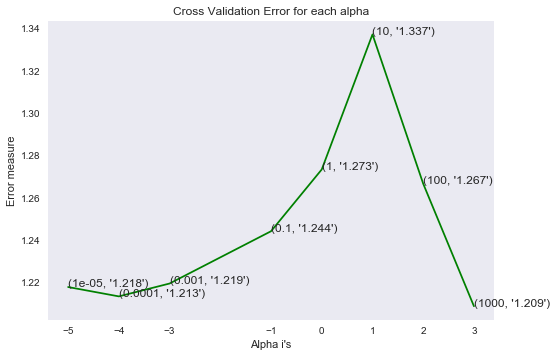

For values of best alpha =  1000 The train log loss is: 0.9379483829885337
For values of best alpha =  1000 The cross validation log loss is: 1.2086151476734708
For values of best alpha =  1000 The test log loss is: 1.1770075248305


In [61]:
#Laplace Smoothing Factor
alpha=[0.00001,0.0001,0.001,0.1,1,10,100,1000]
cv_log_error_array = []
for i in alpha:
    print('Alpha value : ',i)
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotCoding,train_y)
    sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig,ax=plt.subplots()
ax.plot(np.log10(alpha),cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2086151476734708
Number of missclassified point : 0.41353383458646614
-------------------- Confusion matrix --------------------


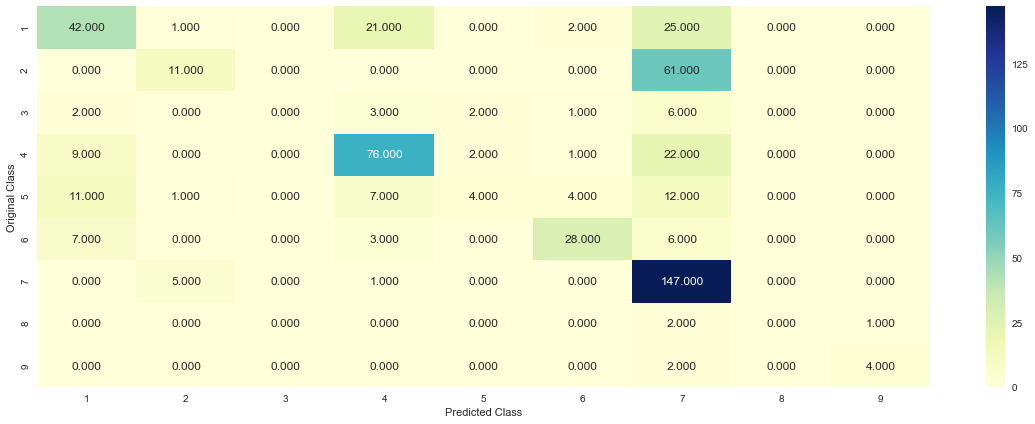

-------------------- Precision matrix (Columm Sum=1) --------------------


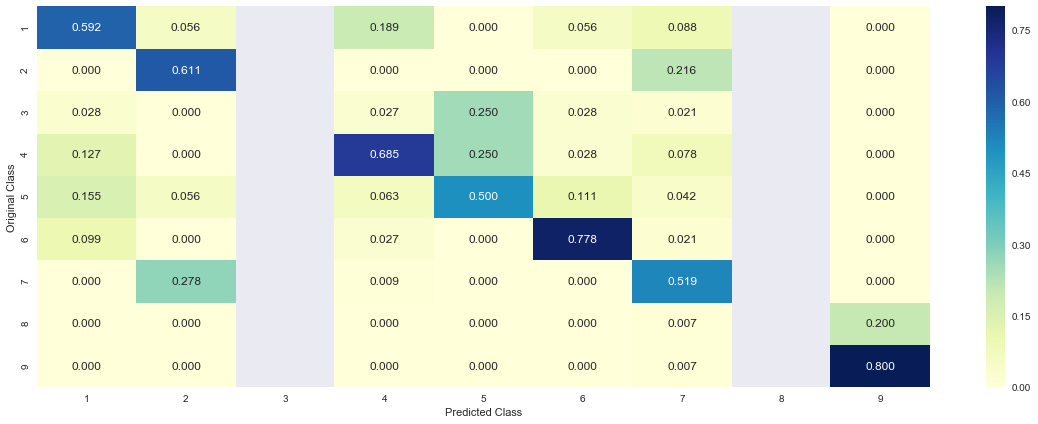

-------------------- Recall matrix (Row sum=1) --------------------


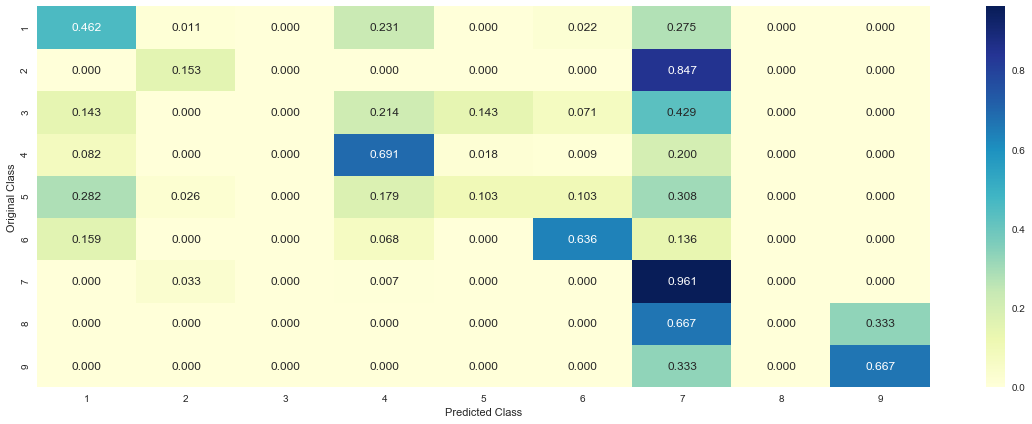

In [62]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

# <h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [63]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0742 0.1899 0.0123 0.0914 0.0365 0.033  0.5586 0.0034 0.0007]]
Actual Class : 7
--------------------------------------------------
14 Text feature [cells] present in test data point [True]
17 Text feature [activated] present in test data point [True]
19 Text feature [kinase] present in test data point [True]
20 Text feature [activation] present in test data point [True]
22 Text feature [cell] present in test data point [True]
23 Text feature [contrast] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [growth] present in test data point [True]
29 Text feature [presence] present in test data point [True]
30 Text feature [signaling] present in test data point [True]
31 Text feature [also] present in test data point [True]
32 Text feature [suggest] present in test data point [True]
33 Text feature [10] present in test data point [True]
34 Text feature [inhibitor] present i

<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [64]:
test_point_indexes=100
no_features=100
predicted_clss=sig_clf.predict(test_x_onehotCoding[test_point_indexes])
print("Predicted Class :", predicted_clss[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_indexes]),4))
print("Actual Class :", test_y[test_point_indexes])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_features]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_indexes],test_df['Gene'].iloc[test_point_indexes],test_df['Variation'].iloc[test_point_indexes], no_features)

Predicted Class : 7
Predicted Class Probabilities: [[0.1851 0.142  0.0218 0.1278 0.0505 0.0498 0.4152 0.0057 0.0021]]
Actual Class : 1
--------------------------------------------------
14 Text feature [cells] present in test data point [True]
19 Text feature [kinase] present in test data point [True]
20 Text feature [activation] present in test data point [True]
21 Text feature [downstream] present in test data point [True]
22 Text feature [cell] present in test data point [True]
23 Text feature [contrast] present in test data point [True]
24 Text feature [factor] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [growth] present in test data point [True]
27 Text feature [shown] present in test data point [True]
29 Text feature [presence] present in test data point [True]
30 Text feature [signaling] present in test data point [True]
31 Text feature [also] present in test data point [True]
32 Text feature [suggest] present 

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 1.0299915013307688
for alpha = 11
Log Loss : 0.9981730049692028
for alpha = 15
Log Loss : 1.0122598752447098
for alpha = 21
Log Loss : 1.0320431789685447
for alpha = 31
Log Loss : 1.0425202699732936
for alpha = 41
Log Loss : 1.0442313403755499
for alpha = 51
Log Loss : 1.057009383112818
for alpha = 99
Log Loss : 1.0816618385968033


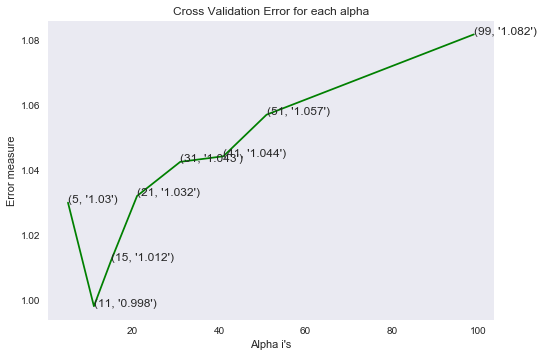

For values of best alpha =  11 The train log loss is: 0.6341297791231436
For values of best alpha =  11 The cross validation log loss is: 0.9981730049692028
For values of best alpha =  11 The test log loss is: 1.0519729572440089


In [65]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    

# <h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 0.9981730049692028
Number of mis-classified points : 0.35150375939849626
-------------------- Confusion matrix --------------------


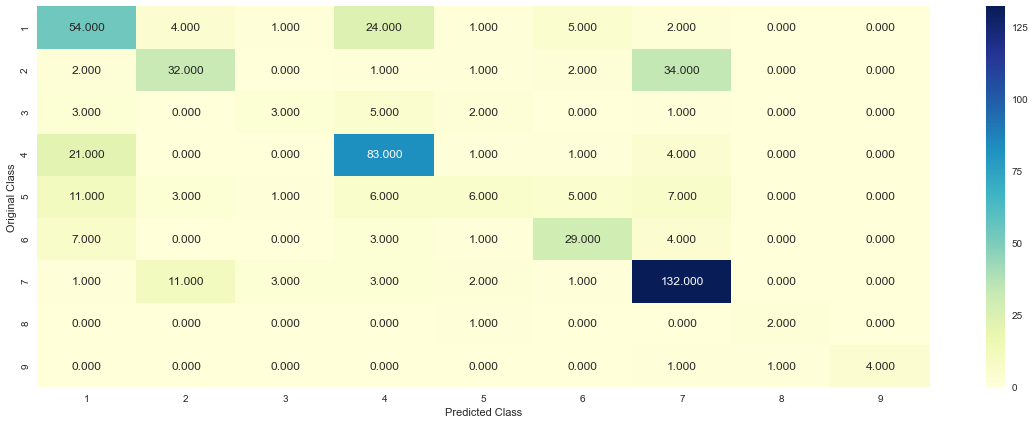

-------------------- Precision matrix (Columm Sum=1) --------------------


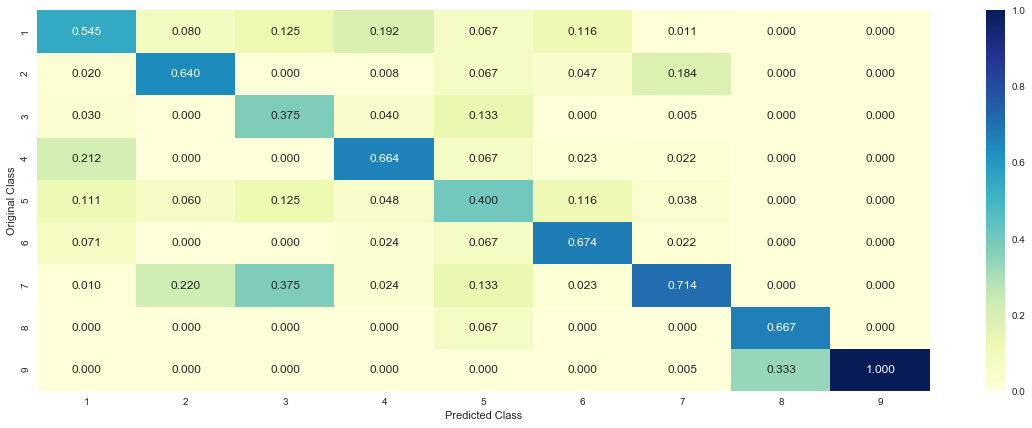

-------------------- Recall matrix (Row sum=1) --------------------


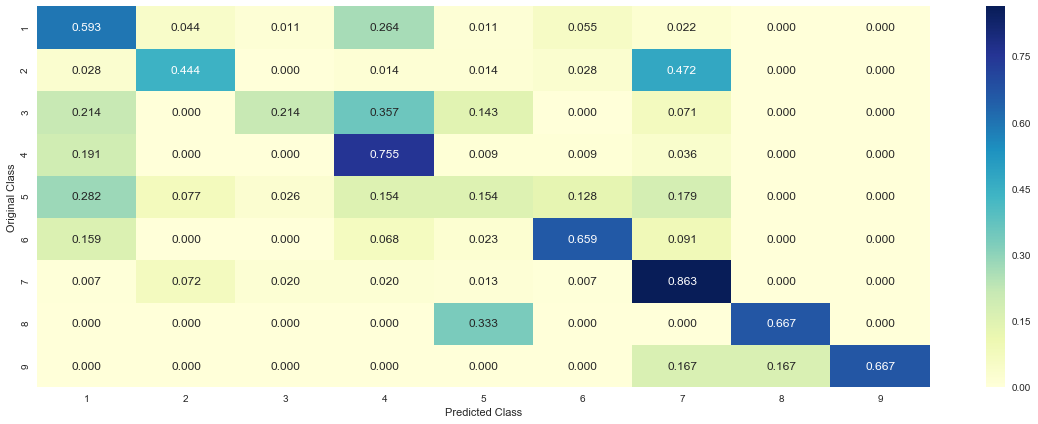

In [66]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [67]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [2 2 2 2 2 5 2 2 2 7 7]
Fequency of nearest points : Counter({2: 8, 7: 2, 5: 1})


<h3>4.2.4. Sample Query Point-2 </h3>

In [68]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [1 1 1 1 1 7 7 7 1 7 9]
Fequency of nearest points : Counter({1: 6, 7: 4, 9: 1})


# 4.3 Logistics Regression

<h3>4.3.1. With Class balancing</h3>

# <h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.280307254387357
for alpha = 1e-05
Log Loss : 1.2827111084147451
for alpha = 0.0001
Log Loss : 1.2062191438224306
for alpha = 0.001
Log Loss : 1.0487851032783304
for alpha = 0.01
Log Loss : 1.0998858653754024
for alpha = 0.1
Log Loss : 1.2005658550223333
for alpha = 1
Log Loss : 1.4058359804796068
for alpha = 10
Log Loss : 1.445734406095718
for alpha = 100
Log Loss : 1.4503913606715533


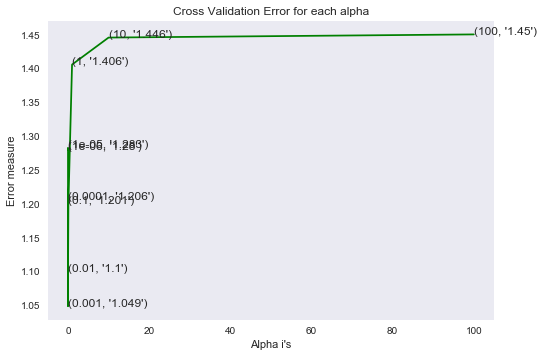

For values of best alpha =  0.001 The train log loss is: 0.5759131993633745
For values of best alpha =  0.001 The cross validation log loss is: 1.0487851032783304
For values of best alpha =  0.001 The test log loss is: 1.0532384125387488


In [69]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

# <h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.0487851032783304
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


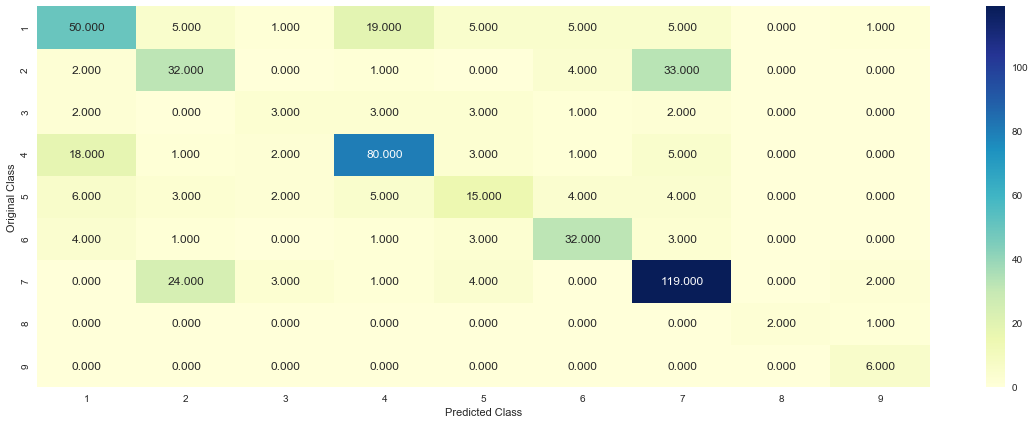

-------------------- Precision matrix (Columm Sum=1) --------------------


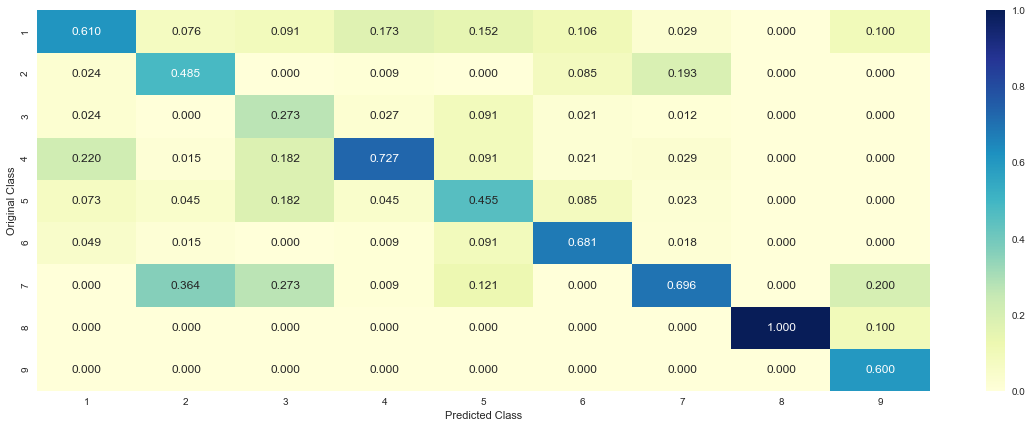

-------------------- Recall matrix (Row sum=1) --------------------


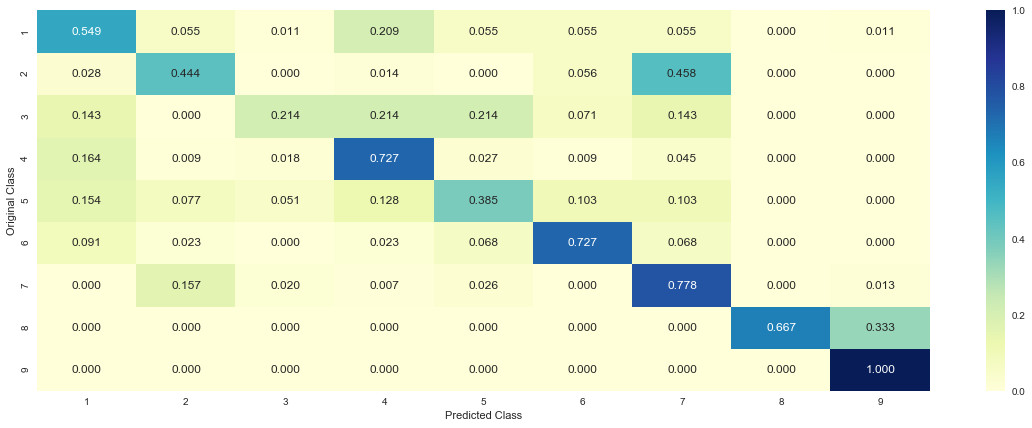

In [70]:
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [71]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [72]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0798 0.2077 0.0139 0.1249 0.0422 0.0255 0.4936 0.0062 0.0063]]
Actual Class : 7
--------------------------------------------------
27 Text feature [activated] present in test data point [True]
182 Text feature [activation] present in test data point [True]
281 Text feature [expressing] present in test data point [True]
496 Text feature [activating] present in test data point [True]
Out of the top  500  features  4 are present in query point


# <h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [73]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5667 0.1018 0.0131 0.0651 0.0331 0.0212 0.187  0.0058 0.0062]]
Actual Class : 1
--------------------------------------------------
112 Text feature [foxa1] present in test data point [True]
165 Text feature [synergy] present in test data point [True]
187 Text feature [endeavors] present in test data point [True]
195 Text feature [slug] present in test data point [True]
277 Text feature [genomes] present in test data point [True]
401 Text feature [zfhx3] present in test data point [True]
448 Text feature [disruptions] present in test data point [True]
499 Text feature [ash2l] present in test data point [True]
Out of the top  500  features  8 are present in query point


<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2455308115992705
for alpha = 1e-05
Log Loss : 1.269183408628771
for alpha = 0.0001
Log Loss : 1.2398424427645958
for alpha = 0.001
Log Loss : 1.0762004183491491
for alpha = 0.01
Log Loss : 1.1536129874793823
for alpha = 0.1
Log Loss : 1.2330678060111169
for alpha = 1
Log Loss : 1.4201380743385106


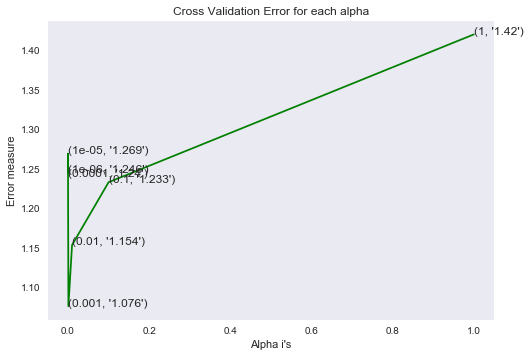

For values of best alpha =  0.001 The train log loss is: 0.5652863693971903
For values of best alpha =  0.001 The cross validation log loss is: 1.0762004183491491
For values of best alpha =  0.001 The test log loss is: 1.0744907099582097


In [74]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.0762004183491491
Number of mis-classified points : 0.36278195488721804
-------------------- Confusion matrix --------------------


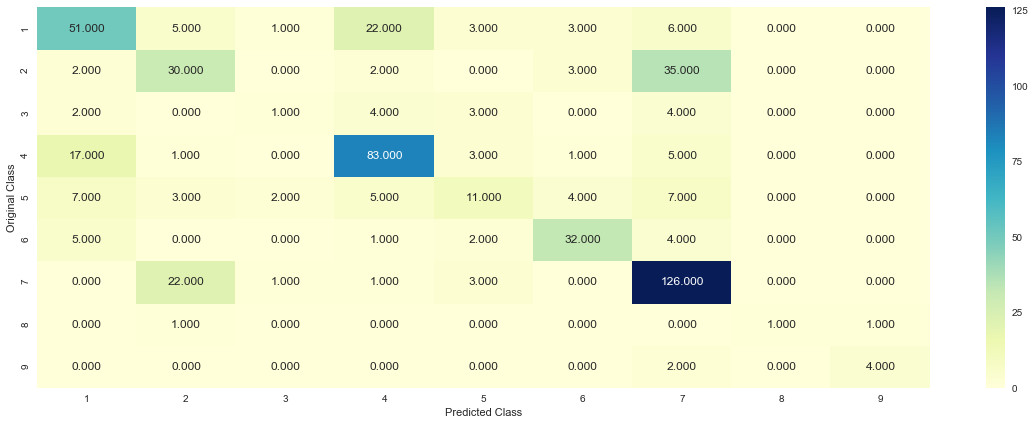

-------------------- Precision matrix (Columm Sum=1) --------------------


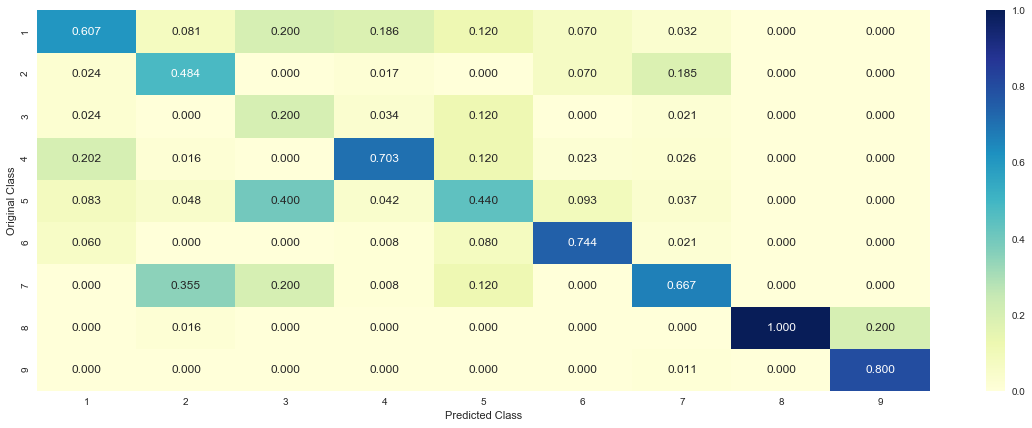

-------------------- Recall matrix (Row sum=1) --------------------


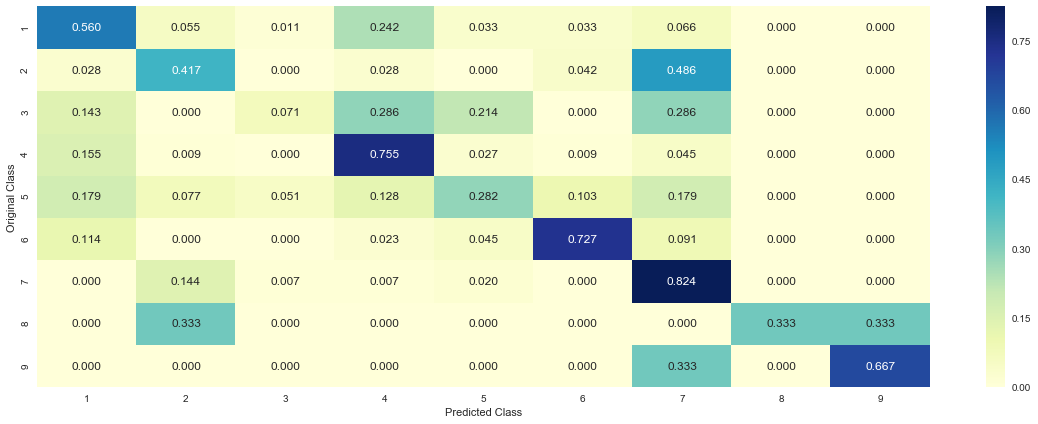

In [75]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [76]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0821 0.2059 0.0129 0.1318 0.0409 0.0253 0.4929 0.0053 0.003 ]]
Actual Class : 7
--------------------------------------------------
79 Text feature [activated] present in test data point [True]
218 Text feature [activation] present in test data point [True]
227 Text feature [expressing] present in test data point [True]
345 Text feature [2d] present in test data point [True]
388 Text feature [activating] present in test data point [True]
434 Text feature [signaling] present in test data point [True]
Out of the top  500  features  6 are present in query point


<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [77]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5718 0.1047 0.0094 0.0718 0.0304 0.0195 0.1864 0.0039 0.0021]]
Actual Class : 1
--------------------------------------------------
114 Text feature [foxa1] present in test data point [True]
164 Text feature [slug] present in test data point [True]
189 Text feature [endeavors] present in test data point [True]
196 Text feature [synergy] present in test data point [True]
293 Text feature [genomes] present in test data point [True]
442 Text feature [zfhx3] present in test data point [True]
473 Text feature [implantations] present in test data point [True]
491 Text feature [3m] present in test data point [True]
498 Text feature [disruptions] present in test data point [True]
Out of the top  500  features  9 are present in query point


<h2>4.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2749232657118958
for C = 0.0001
Log Loss : 1.2677762883047565
for C = 0.001
Log Loss : 1.1812988878095034
for C = 0.01
Log Loss : 1.1151400802188138
for C = 0.1
Log Loss : 1.2256947367465019
for C = 1
Log Loss : 1.4511172551224147
for C = 10
Log Loss : 1.4511751015415633
for C = 100
Log Loss : 1.4511750775200876


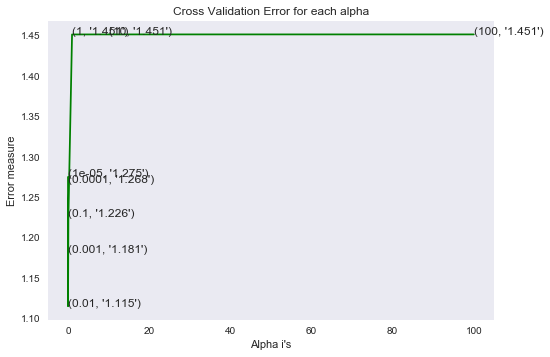

For values of best alpha =  0.01 The train log loss is: 0.6920783888314407
For values of best alpha =  0.01 The cross validation log loss is: 1.1151400802188138
For values of best alpha =  0.01 The test log loss is: 1.07349664971486


In [78]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1151400802188138
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


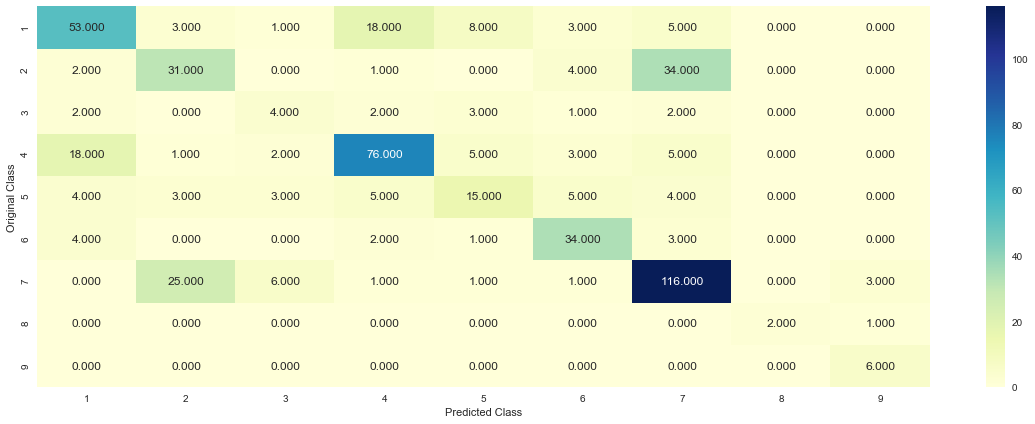

-------------------- Precision matrix (Columm Sum=1) --------------------


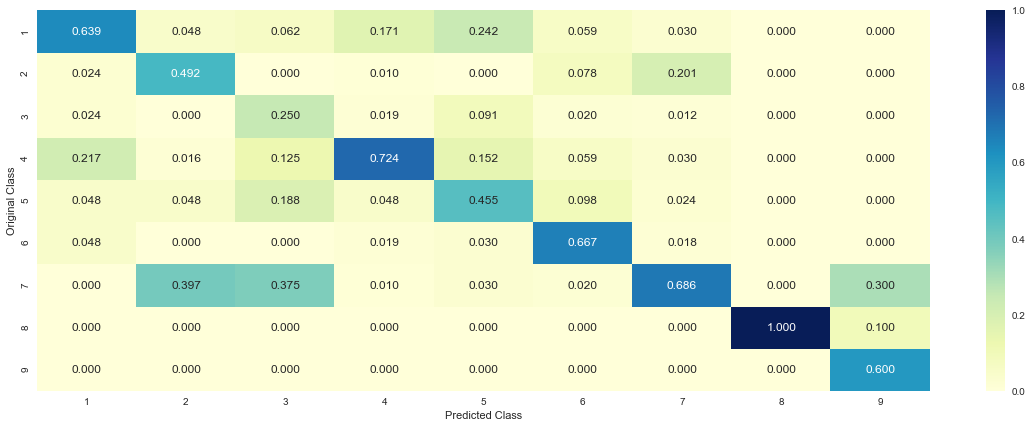

-------------------- Recall matrix (Row sum=1) --------------------


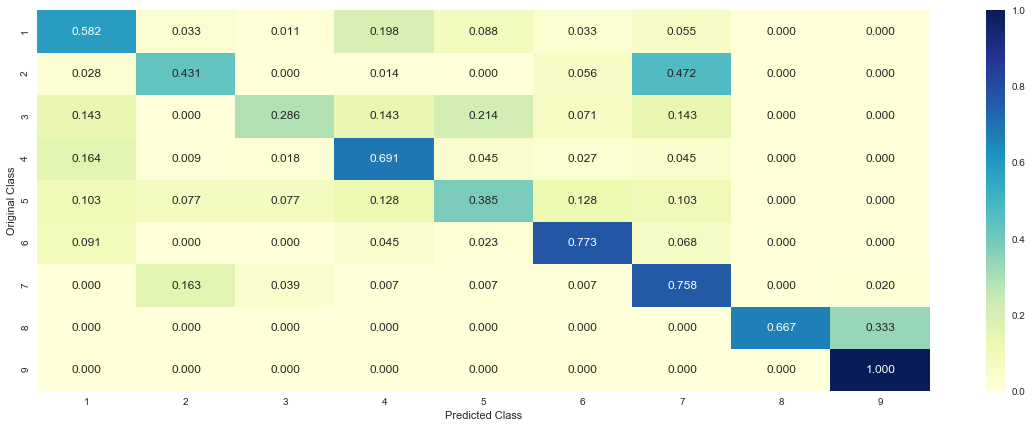

In [79]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [80]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1149 0.1951 0.0128 0.148  0.0492 0.0322 0.4379 0.0053 0.0046]]
Actual Class : 7
--------------------------------------------------
34 Text feature [activated] present in test data point [True]
56 Text feature [activation] present in test data point [True]
57 Text feature [expressing] present in test data point [True]
133 Text feature [activating] present in test data point [True]
152 Text feature [2d] present in test data point [True]
210 Text feature [inhibitor] present in test data point [True]
229 Text feature [course] present in test data point [True]
347 Text feature [signaling] present in test data point [True]
424 Text feature [2f] present in test data point [True]
484 Text feature [treating] present in test data point [True]
Out of the top  500  features  10 are present in query point


<h4>4.3.3.2. For Incorrectly classified point</h4>

In [81]:
test_point_index = 300
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding)
print("Predicted Class :", predicted_cls[test_point_index])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.834  0.0645 0.0074 0.0302 0.0209 0.0126 0.0238 0.0042 0.0024]]
Actual Class : 1
--------------------------------------------------
57 Text feature [expressing] present in test data point [True]
63 Text feature [technology] present in test data point [True]
166 Text feature [doses] present in test data point [True]
170 Text feature [exchange] present in test data point [True]
187 Text feature [transformed] present in test data point [True]
210 Text feature [inhibitor] present in test data point [True]
245 Text feature [elevated] present in test data point [True]
273 Text feature [fbs] present in test data point [True]
276 Text feature [phosphorylation] present in test data point [True]
322 Text feature [proportional] present in test data point [True]
347 Text feature [signaling] present in test data point [True]
419 Text feature [concentrations] present in test data point [True]
643 Text feature [enhanced] present in test data point

<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [126]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2176182532636342
for n_estimators = 100 and max depth =  10
Log Loss : 1.15228519032339
for n_estimators = 200 and max depth =  5
Log Loss : 1.197002411210716
for n_estimators = 200 and max depth =  10
Log Loss : 1.1410891972513473
for n_estimators = 500 and max depth =  5
Log Loss : 1.1833474532330217
for n_estimators = 500 and max depth =  10
Log Loss : 1.1337140093794404
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1880192329789174
for n_estimators = 1000 and max depth =  10
Log Loss : 1.128915153116355
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1890340447316057
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1274082800675007
For values of best estimator =  2000 The train log loss is: 0.6423370136589692
For values of best estimator =  2000 The cross validation log loss is: 1.1274082800675007
For values of best estimator =  2000 The test log loss is: 1.1372811368672848


<h3>4.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1382306792
Number of mis-classified points : 0.35902255639097747
-------------------- Confusion matrix --------------------


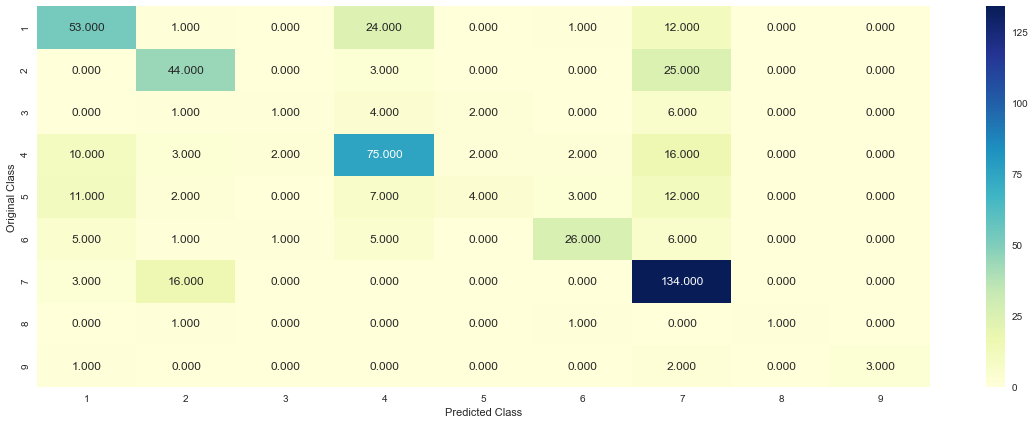

-------------------- Precision matrix (Columm Sum=1) --------------------


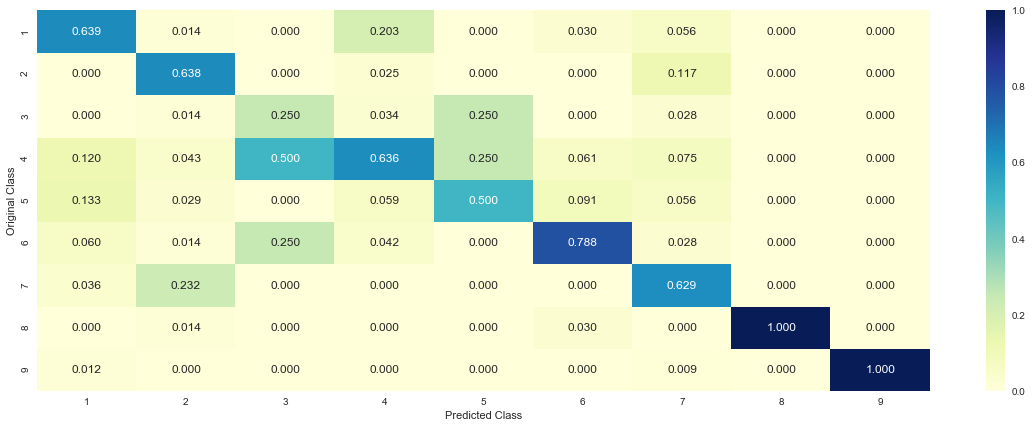

-------------------- Recall matrix (Row sum=1) --------------------


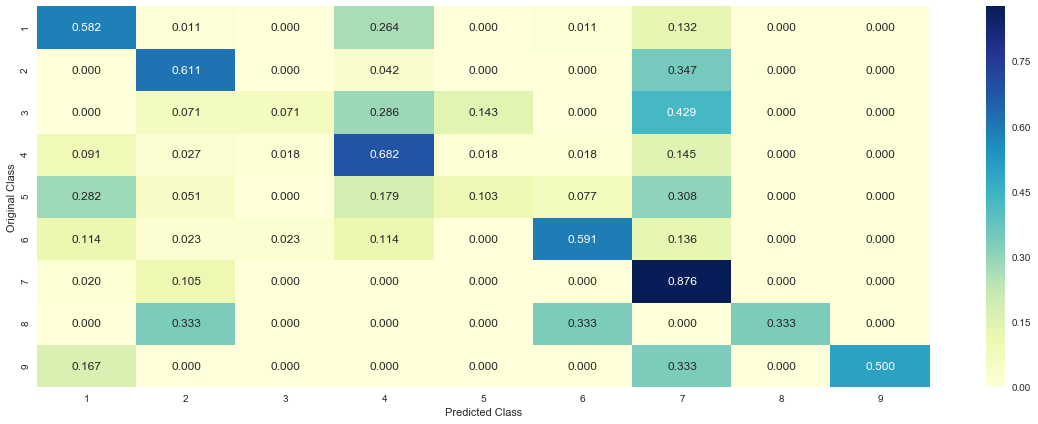

In [97]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h4>4.5.3.2. Inorrectly Classified point</h4>

In [ ]:
test_point_index = 300
no_feature = 1000
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

<h3>4.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [100]:


alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.18974195274
for n_estimators = 10 and max depth =  3
Log Loss : 1.67589428187
for n_estimators = 10 and max depth =  5
Log Loss : 1.43271357424
for n_estimators = 10 and max depth =  10
Log Loss : 2.02381796923
for n_estimators = 50 and max depth =  2
Log Loss : 1.69348944917
for n_estimators = 50 and max depth =  3
Log Loss : 1.37728591283
for n_estimators = 50 and max depth =  5
Log Loss : 1.31962983531
for n_estimators = 50 and max depth =  10
Log Loss : 1.7785146031
for n_estimators = 100 and max depth =  2
Log Loss : 1.58481401341
for n_estimators = 100 and max depth =  3
Log Loss : 1.37879755623
for n_estimators = 100 and max depth =  5
Log Loss : 1.26037512767
for n_estimators = 100 and max depth =  10
Log Loss : 1.67276629375
for n_estimators = 200 and max depth =  2
Log Loss : 1.58762781393
for n_estimators = 200 and max depth =  3
Log Loss : 1.40136431253
for n_estimators = 200 and max depth =  5
Log Loss : 1.27445015725
f

<h3>4.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.26037512767
Number of mis-classified points : 0.4417293233082707
-------------------- Confusion matrix --------------------


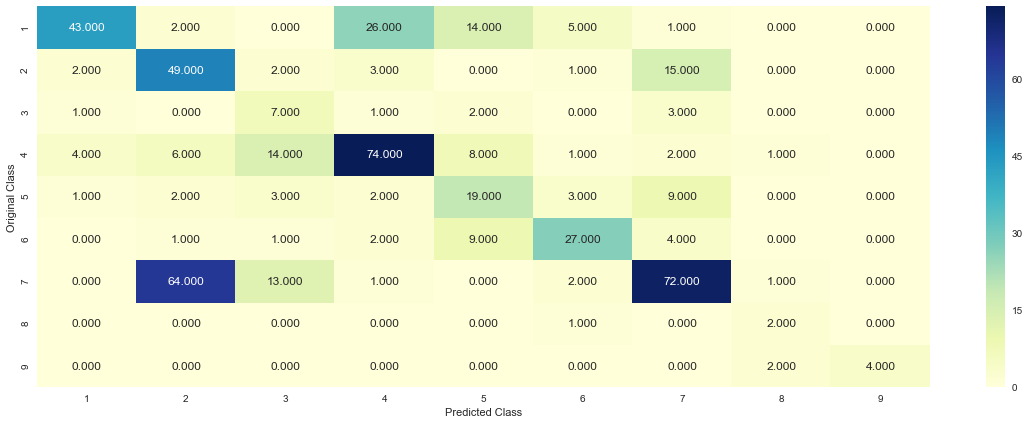

-------------------- Precision matrix (Columm Sum=1) --------------------


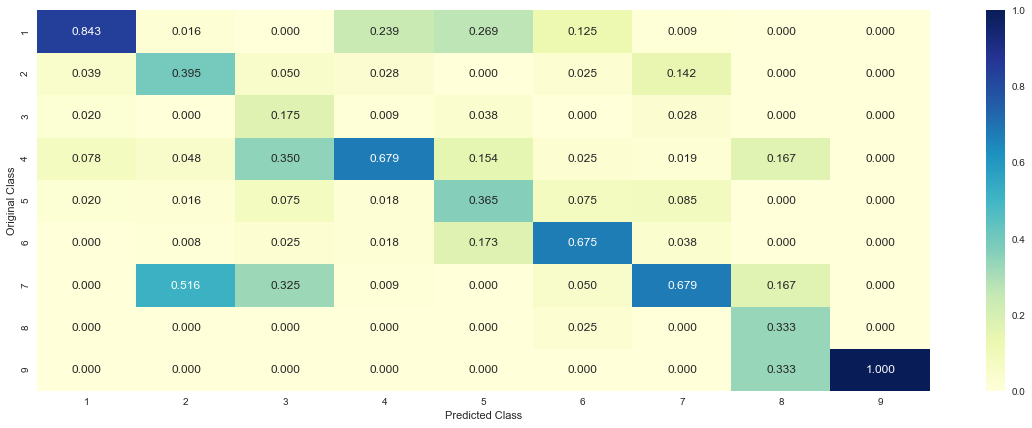

-------------------- Recall matrix (Row sum=1) --------------------


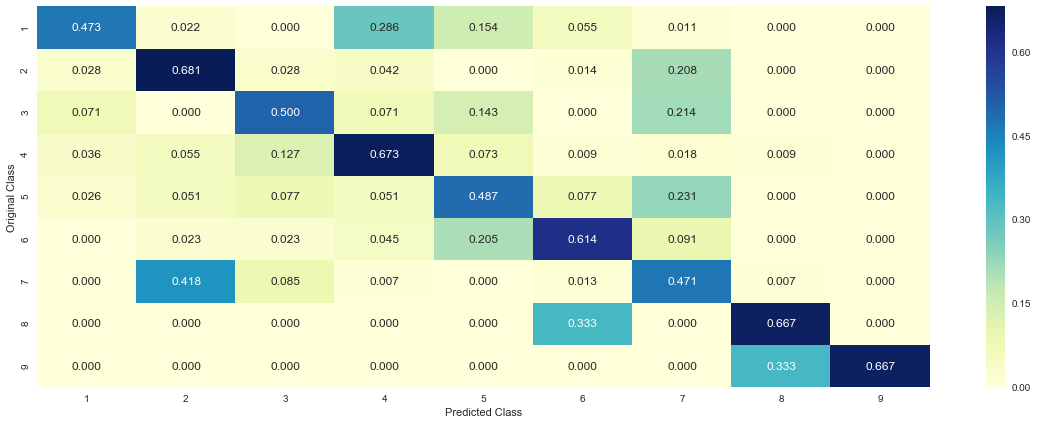

In [102]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

<h3>4.5.5. Feature Importance</h3>

<h4>4.5.5.1. Correctly Classified point</h4>

In [103]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[ 0.0083  0.7054  0.0637  0.0139  0.0193  0.0207  0.1518  0.0082  0.0087]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature


<h4>4.5.5.2. Incorrectly Classified point</h4>

In [105]:
test_point_index = 300
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[ 0.0022  0.0062  0.0019  0.0043  0.0013  0.0033  0.9743  0.0029  0.0036]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature


<h2>4.7 Stack the models </h2>

<h3>4.7.1 testing with hyper parameter tuning</h3>

In [106]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.01
Support vector machines : Log Loss: 1.48
Naive Bayes : Log Loss: 1.21
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.035
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.491
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.059
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.096
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.267


<h3>4.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.663806122166
Log loss (CV) on the stacking classifier : 1.05947274029
Log loss (test) on the stacking classifier : 1.17019106945
Number of missclassified point : 0.3954887218045113
-------------------- Confusion matrix --------------------


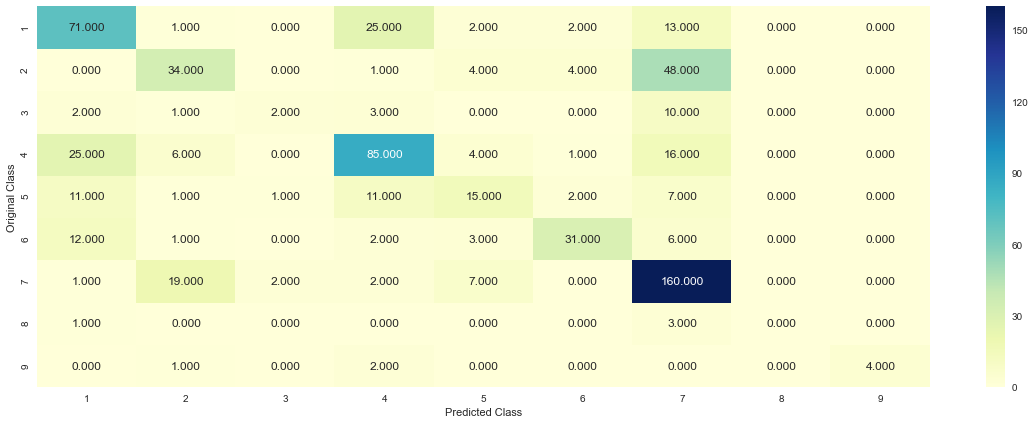

-------------------- Precision matrix (Columm Sum=1) --------------------


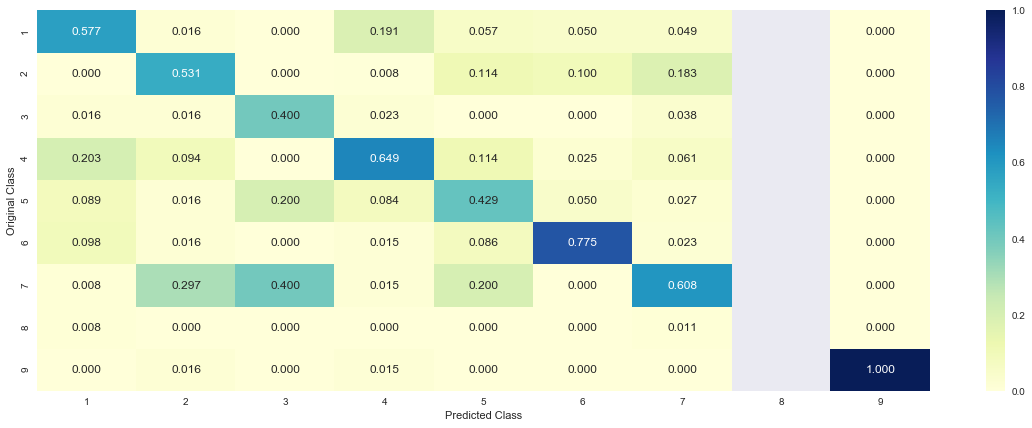

-------------------- Recall matrix (Row sum=1) --------------------


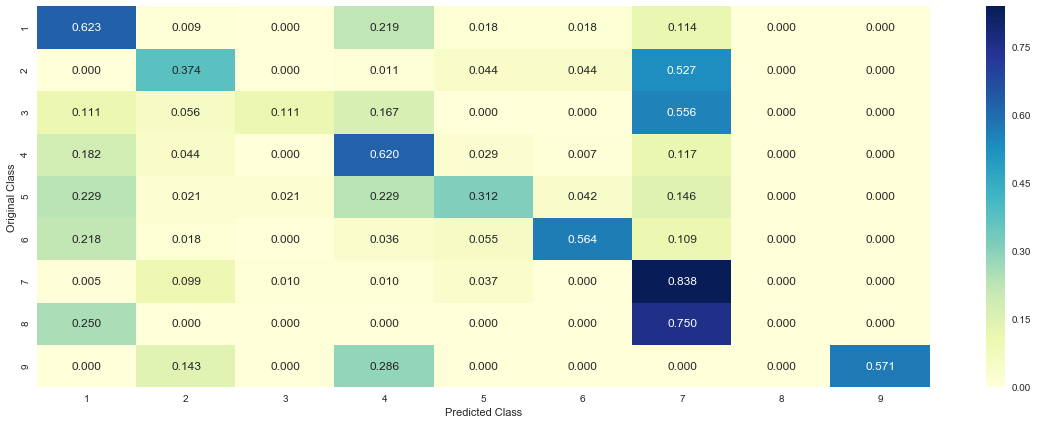

In [107]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>4.7.3 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.879018472648
Log loss (CV) on the VotingClassifier : 1.12468688581
Log loss (test) on the VotingClassifier : 1.17071092183
Number of missclassified point : 0.38646616541353385
-------------------- Confusion matrix --------------------


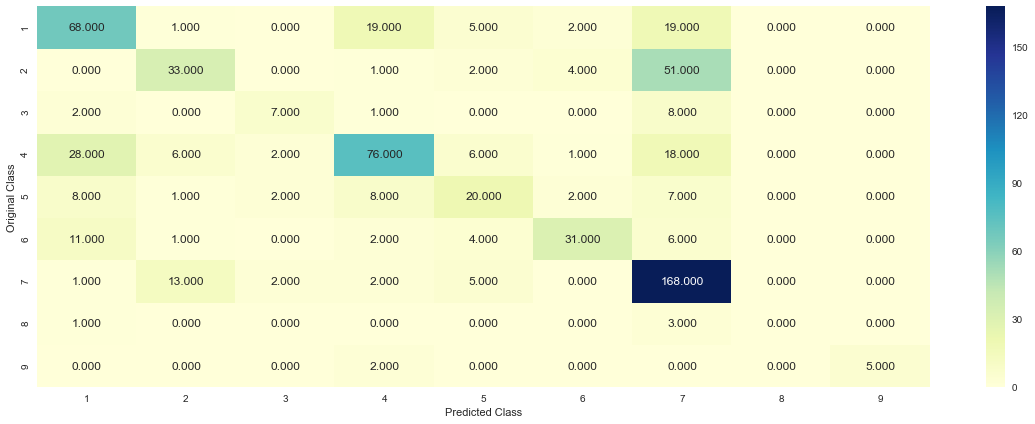

-------------------- Precision matrix (Columm Sum=1) --------------------


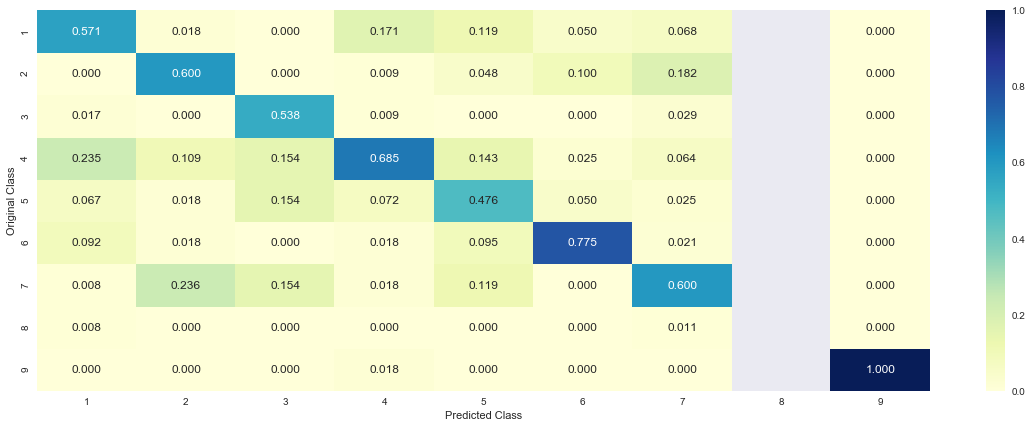

-------------------- Recall matrix (Row sum=1) --------------------


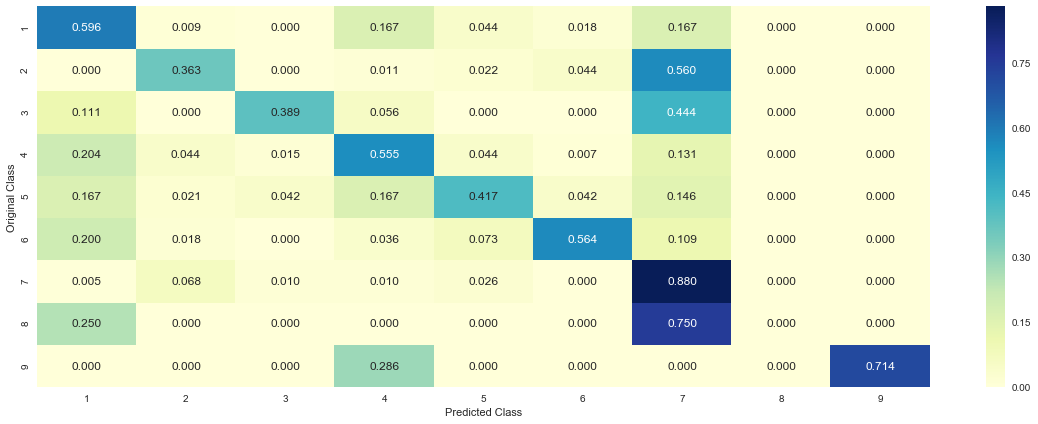

In [108]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values

In [55]:
sorted_words=list(sorted_text_fea_dict.keys())
sorted_words_1000=sorted_words[0:1000]
tfidf=TfidfVectorizer(max_features=1000,vocabulary=sorted_words_1000)
train_text_feature_onehotCoding_1000=tfidf.fit_transform(train_df['TEXT'])

In [56]:
train_text_feature_onehotCoding_1000.shape

(2124, 1000)

In [57]:
train_text_features= tfidf.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding_1000.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [58]:
# don't forget to normalize every feature
train_text_feature_onehotCoding_1000 = normalize(train_text_feature_onehotCoding_1000, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding_1000 = tfidf.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding_1000 = normalize(test_text_feature_onehotCoding_1000, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding_1000 = tfidf.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding_1000 = normalize(cv_text_feature_onehotCoding_1000, axis=0)

In [59]:
cv_text_feature_onehotCoding_1000.shape

(532, 1000)

In [128]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

For values of alpha =  1e-05 The log loss is: 1.13839336736
For values of alpha =  0.0001 The log loss is: 1.18085814833
For values of alpha =  0.001 The log loss is: 1.40063970181
For values of alpha =  0.01 The log loss is: 1.7866182808
For values of alpha =  0.1 The log loss is: 2.00862975063
For values of alpha =  1 The log loss is: 2.0041545571


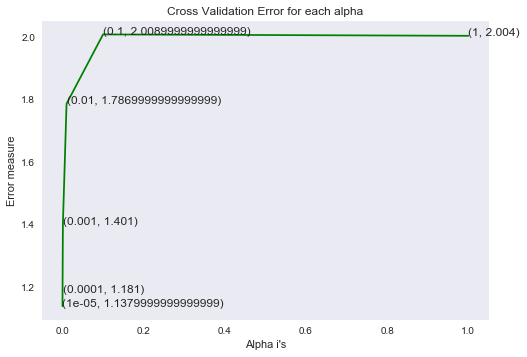

For values of best alpha =  1e-05 The train log loss is: 0.790646795172
For values of best alpha =  1e-05 The cross validation log loss is: 1.13839336736
For values of best alpha =  1e-05 The test log loss is: 1.11299477189


In [60]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding_1000, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding_1000, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding_1000)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding_1000, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding_1000, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding_1000)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding_1000)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding_1000)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Stacking three type of features

In [143]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))


train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding_1000)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding_1000)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding_1000)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [65]:
train_gene_feature_onehotCoding.shape

(2124, 234)

In [67]:
train_variation_feature_onehotCoding.shape

(2124, 1948)

In [145]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3194)
(number of data points * number of features) in test data =  (665, 3194)
(number of data points * number of features) in cross validation data = (532, 3194)


<h2>5.1. Base Line Model</h2>

<h3>5.1.1. Naive Bayes</h3>

<h4>5.1.1.1. Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.12018126918
for alpha = 0.0001
Log Loss : 1.12080442997
for alpha = 0.001
Log Loss : 1.12081065889
for alpha = 0.1
Log Loss : 1.13477880776
for alpha = 1
Log Loss : 1.26039619749
for alpha = 10
Log Loss : 1.4465520541
for alpha = 100
Log Loss : 1.38456549863
for alpha = 1000
Log Loss : 1.37282851356


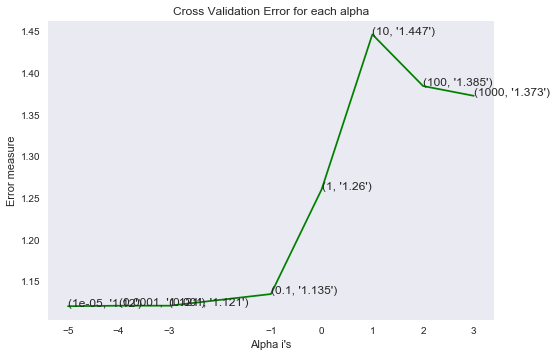

For values of best alpha =  1e-05 The train log loss is: 0.533166215585
For values of best alpha =  1e-05 The cross validation log loss is: 1.12018126918
For values of best alpha =  1e-05 The test log loss is: 1.19675841757


In [146]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.12018126918
Number of missclassified point : 0.33646616541353386
-------------------- Confusion matrix --------------------


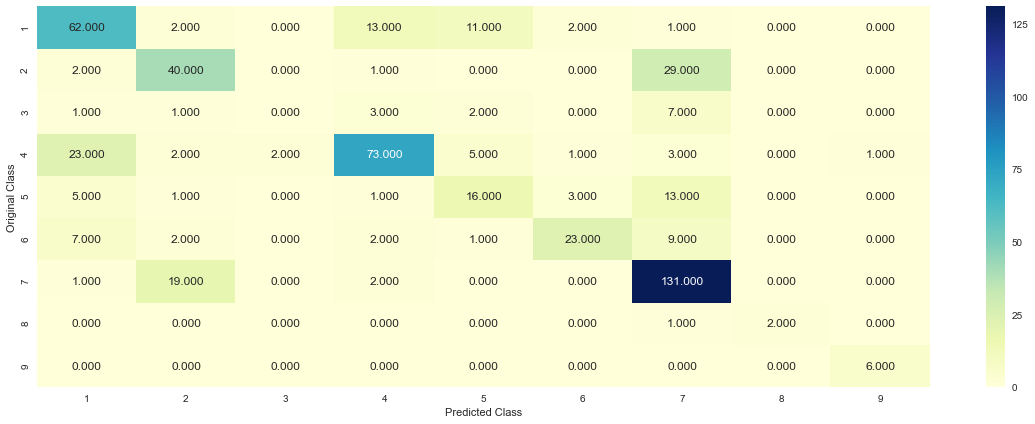

-------------------- Precision matrix (Columm Sum=1) --------------------


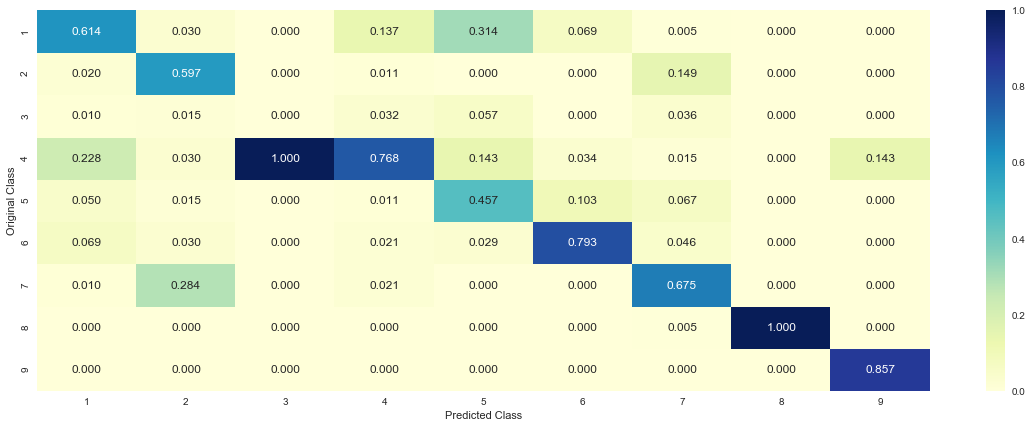

-------------------- Recall matrix (Row sum=1) --------------------


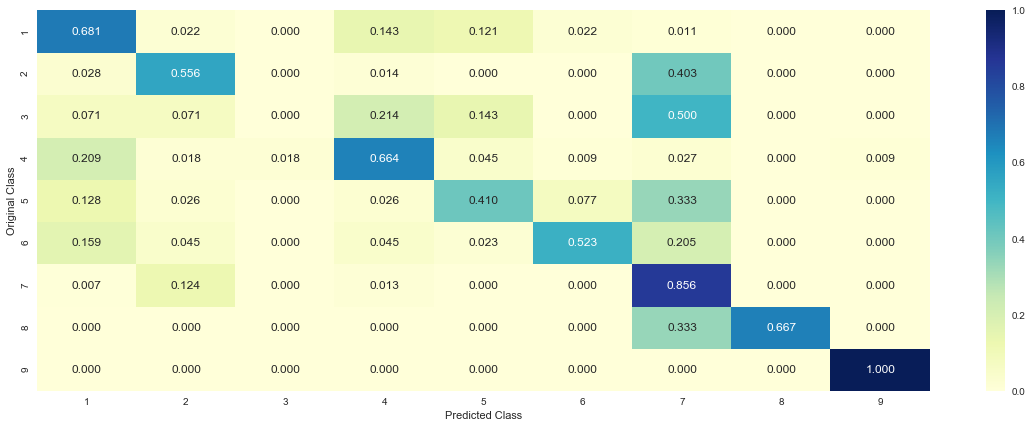

In [147]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>5.1.1.3. Feature Importance, Correctly classified point</h4>

In [148]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[ 0.0746  0.4568  0.0133  0.0792  0.04    0.0372  0.2921  0.0039  0.0028]]
Actual Class : 2
--------------------------------------------------
47 Text feature [013] present in test data point [True]
Out of the top  100  features  1 are present in query point


<h4>5.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [149]:
test_point_index = 300
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[ 0.063   0.2516  0.0114  0.067   0.0334  0.0313  0.5366  0.0033  0.0024]]
Actual Class : 2
--------------------------------------------------
167 Text feature [115150] present in test data point [True]
Out of the top  500  features  1 are present in query point


<h2>5.2. K Nearest Neighbour Classification</h2>

<h3>5.2.1. Hyper parameter tuning</h3>

for alpha = 5
Log Loss : 0.993728095725
for alpha = 11
Log Loss : 0.956123950141
for alpha = 15
Log Loss : 0.963626058321
for alpha = 21
Log Loss : 0.963403754729
for alpha = 31
Log Loss : 0.983210955401
for alpha = 41
Log Loss : 0.986535067743
for alpha = 51
Log Loss : 0.991606591391
for alpha = 99
Log Loss : 1.03249565246


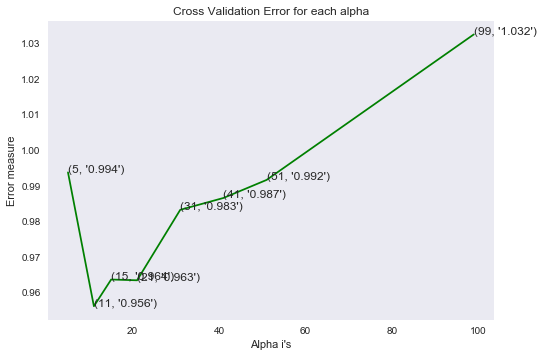

For values of best alpha =  11 The train log loss is: 0.641168799295
For values of best alpha =  11 The cross validation log loss is: 0.956123950141
For values of best alpha =  11 The test log loss is: 1.04990158174


In [150]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>5.2.2. Testing the model with best hyper paramters</h3>

Log loss : 0.956123950141
Number of mis-classified points : 0.3308270676691729
-------------------- Confusion matrix --------------------


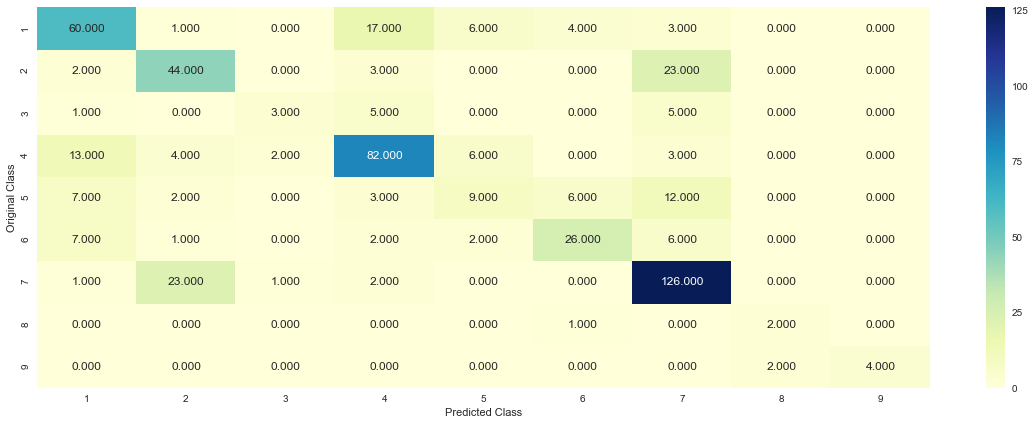

-------------------- Precision matrix (Columm Sum=1) --------------------


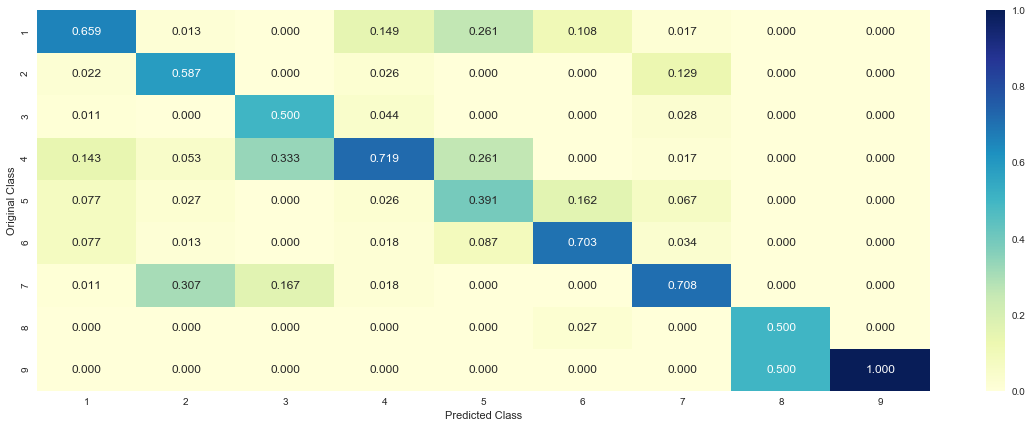

-------------------- Recall matrix (Row sum=1) --------------------


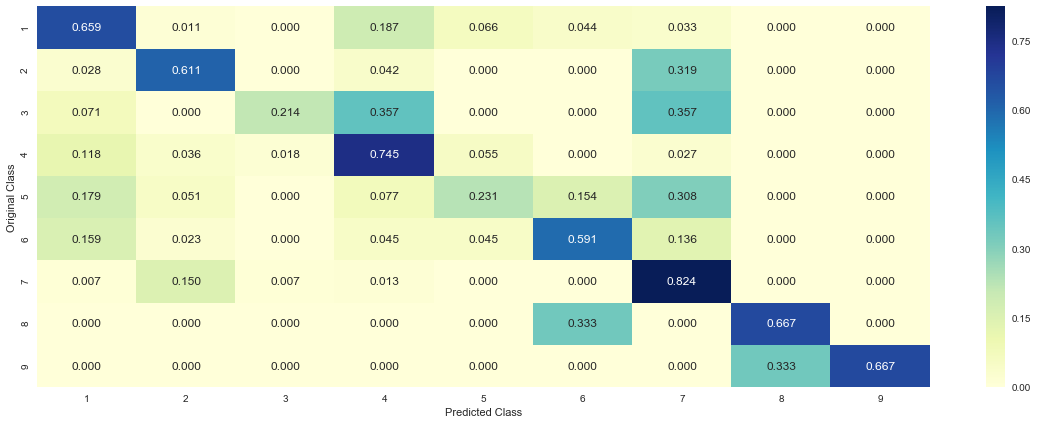

In [151]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>5.2.3.Sample Query point -1</h3>

In [154]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [2 7 7 7 2 2 7 7 7 7 7]
Fequency of nearest points : Counter({7: 8, 2: 3})


<h3>5.2.3.Sample Query point -2</h3>

In [155]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 1 4 4 4 4]
Fequency of nearest points : Counter({4: 10, 1: 1})


<h2>5.3. Logistic Regression</h2>

<h3>5.3.1. With Class balancing</h3>

<h4>5.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.03801130343
for alpha = 1e-05
Log Loss : 0.982502425786
for alpha = 0.0001
Log Loss : 0.922813031273
for alpha = 0.001
Log Loss : 0.934485358042
for alpha = 0.01
Log Loss : 1.1332892331
for alpha = 0.1
Log Loss : 1.52998221867
for alpha = 1
Log Loss : 1.68444630512
for alpha = 10
Log Loss : 1.70450628409
for alpha = 100
Log Loss : 1.70688390831


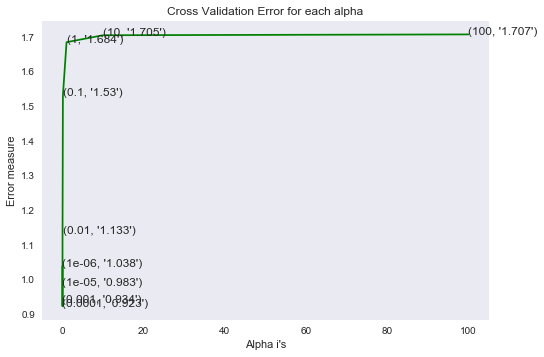

For values of best alpha =  0.0001 The train log loss is: 0.449946872074
For values of best alpha =  0.0001 The cross validation log loss is: 0.922813031273
For values of best alpha =  0.0001 The test log loss is: 1.02417981012


In [165]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>5.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 0.922813031273
Number of mis-classified points : 0.3233082706766917
-------------------- Confusion matrix --------------------


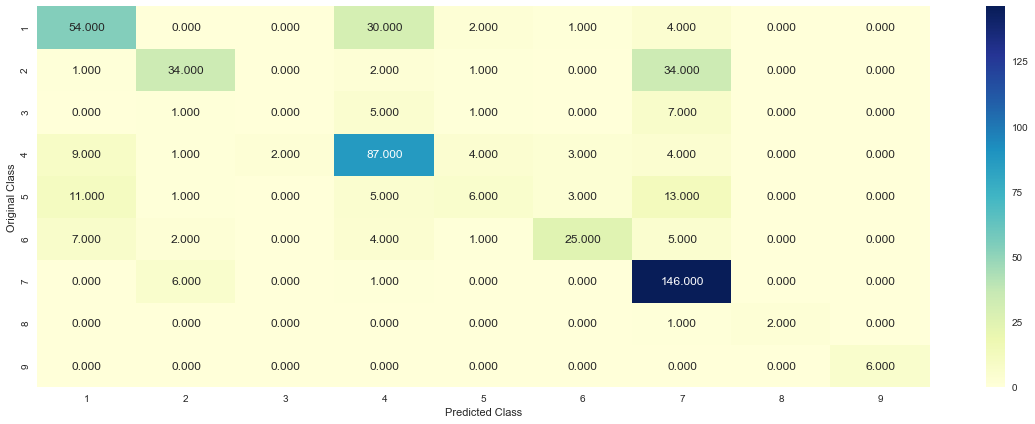

-------------------- Precision matrix (Columm Sum=1) --------------------


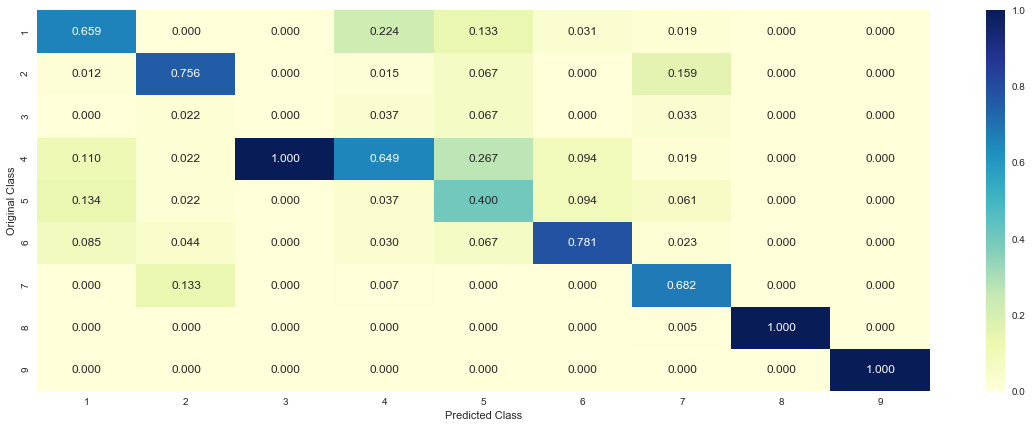

-------------------- Recall matrix (Row sum=1) --------------------


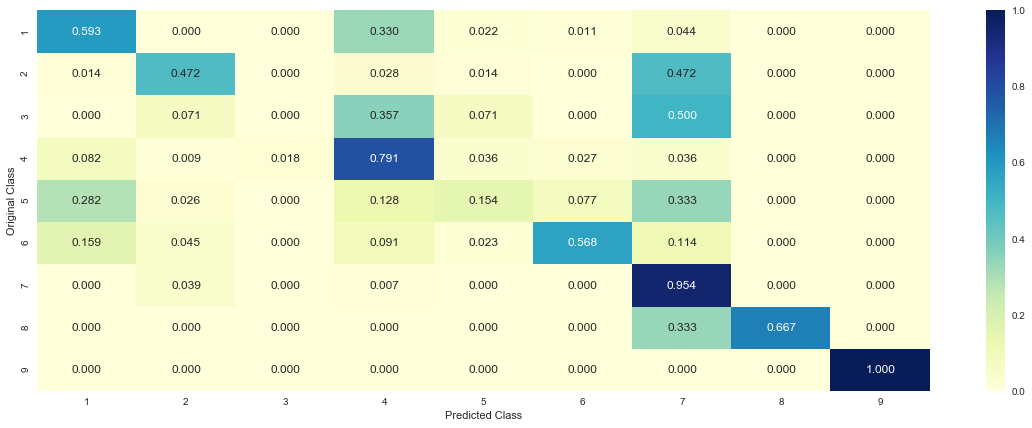

In [166]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

<h4>5.3.1.3. Feature Importance</h4>

In [168]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>5.3.1.3.1. Correctly Classified point</h5>

In [169]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[ 0.0087  0.537   0.0013  0.0084  0.0075  0.0101  0.4242  0.0021  0.0008]]
Actual Class : 2
--------------------------------------------------
294 Text feature [008] present in test data point [True]
311 Text feature [13] present in test data point [True]
316 Text feature [012] present in test data point [True]
337 Text feature [035] present in test data point [True]
386 Text feature [085] present in test data point [True]
412 Text feature [11] present in test data point [True]
439 Text feature [011] present in test data point [True]
452 Text feature [045] present in test data point [True]
Out of the top  500  features  8 are present in query point


<h5>5.3.1.3.2. Incorrectly Classified point</h5>

In [171]:
test_point_index = 300
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[  1.55000000e-02   4.65800000e-01   4.00000000e-04   2.06000000e-02
    2.80000000e-03   4.90000000e-03   4.86500000e-01   3.30000000e-03
    2.00000000e-04]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h3>5.3.2. Without Class balancing</h3>

<h4>5.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.08308169585
for alpha = 1e-05
Log Loss : 1.04510120656
for alpha = 0.0001
Log Loss : 0.947296516538
for alpha = 0.001
Log Loss : 1.01748785798
for alpha = 0.01
Log Loss : 1.26847290962
for alpha = 0.1
Log Loss : 1.62124325714
for alpha = 1
Log Loss : 1.75543185666


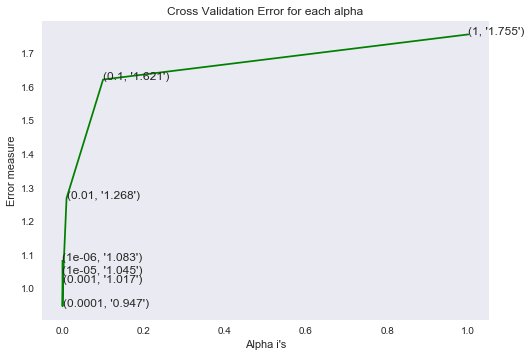

For values of best alpha =  0.0001 The train log loss is: 0.442958234795
For values of best alpha =  0.0001 The cross validation log loss is: 0.947296516538
For values of best alpha =  0.0001 The test log loss is: 1.03910538711


In [172]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>5.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.4804079103577146
Number of mis-classified points : 0.47368421052631576
-------------------- Confusion matrix --------------------


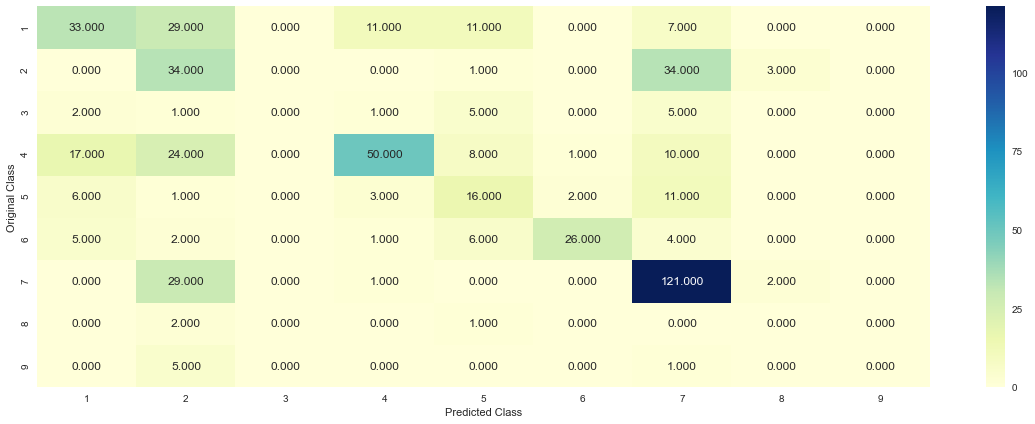

-------------------- Precision matrix (Columm Sum=1) --------------------


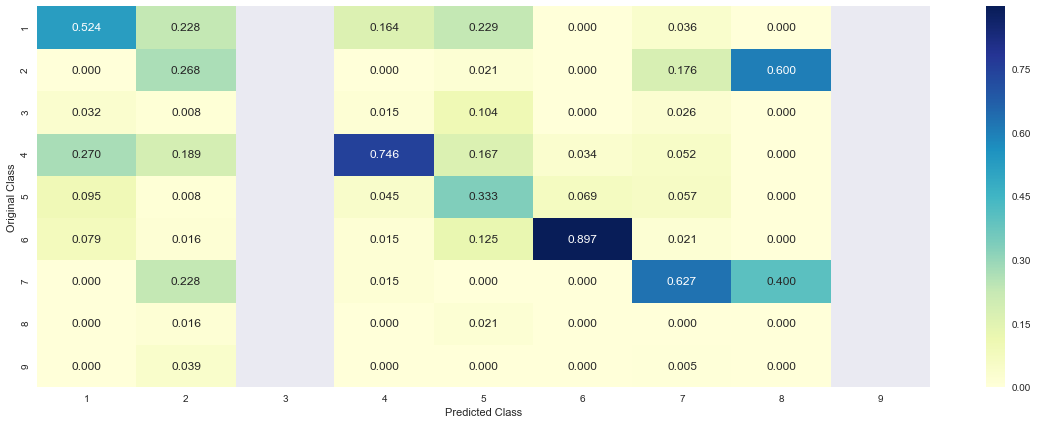

-------------------- Recall matrix (Row sum=1) --------------------


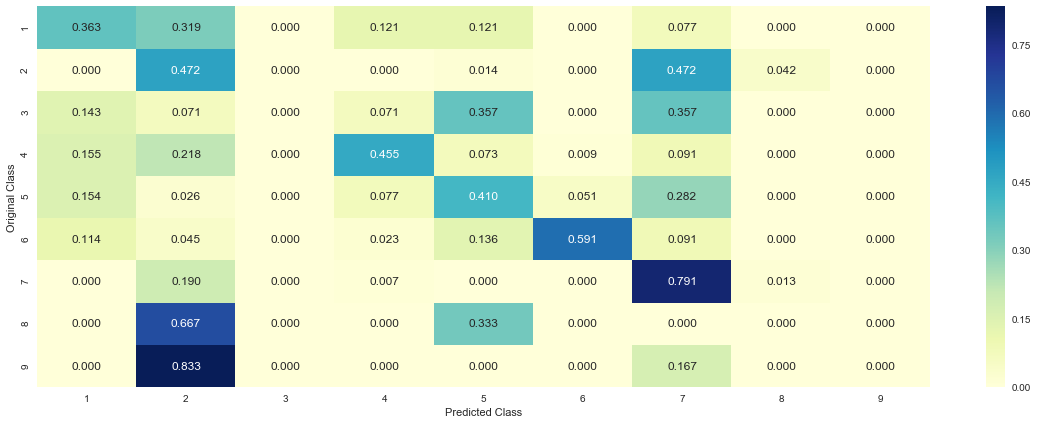

In [84]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

# <h4>5.3.2.3. Feature Importance, Correctly Classified point</h4>

In [90]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 300
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6005 0.1239 0.0194 0.0684 0.0483 0.0456 0.0814 0.007  0.0055]]
Actual Class : 1
--------------------------------------------------
18 Text feature [ner] present in test data point [True]
19 Text feature [ercc2] present in test data point [True]
26 Text feature [trichothiodystrophy] present in test data point [True]
55 Text feature [archaebacterial] present in test data point [True]
300 Text feature [ttd] present in test data point [True]
313 Text feature [attr] present in test data point [True]
Out of the top  500  features  6 are present in query point


# <h4>5.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [92]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1377 0.2311 0.0278 0.1049 0.0625 0.0604 0.3594 0.0079 0.0082]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


<h2>5.4. Linear Support Vector Machines</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2749232657118958
for C = 0.0001
Log Loss : 1.2677762883047565
for C = 0.001
Log Loss : 1.1812988878095034
for C = 0.01
Log Loss : 1.1151400802188138
for C = 0.1
Log Loss : 1.2256947367465019
for C = 1
Log Loss : 1.4511172551224147
for C = 10
Log Loss : 1.4511751015415633
for C = 100
Log Loss : 1.4511750775200876


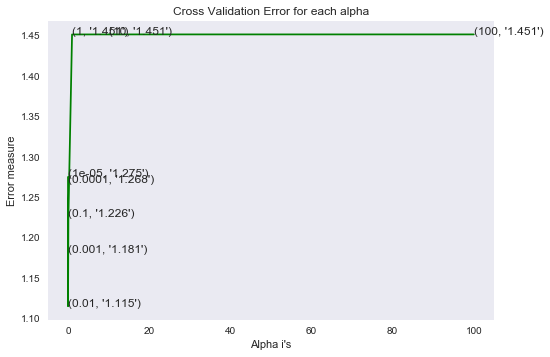

For values of best alpha =  0.01 The train log loss is: 0.6920783888314407
For values of best alpha =  0.01 The cross validation log loss is: 1.1151400802188138
For values of best alpha =  0.01 The test log loss is: 1.07349664971486


In [93]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>5.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.1151400802188138
Number of mis-classified points : 0.36654135338345867
-------------------- Confusion matrix --------------------


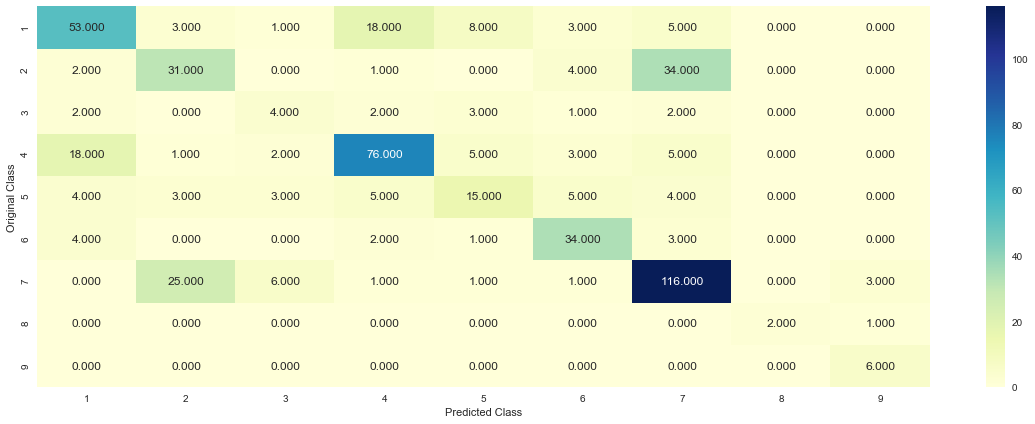

-------------------- Precision matrix (Columm Sum=1) --------------------


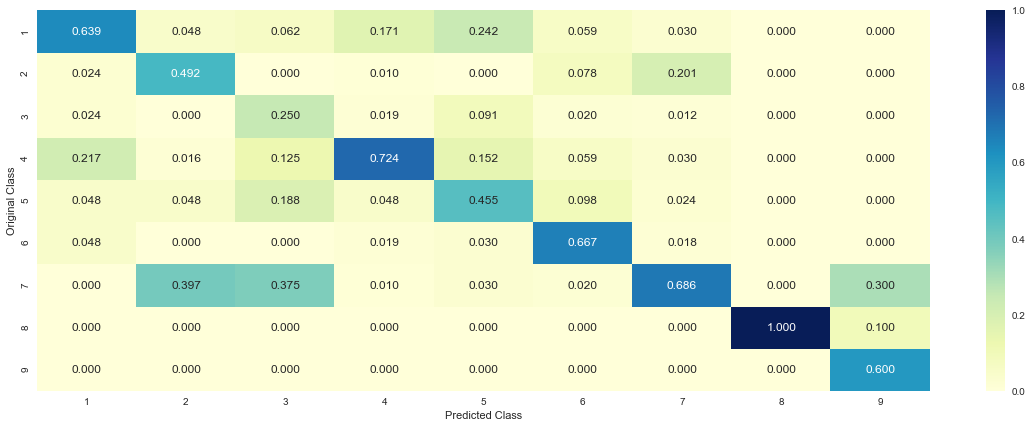

-------------------- Recall matrix (Row sum=1) --------------------


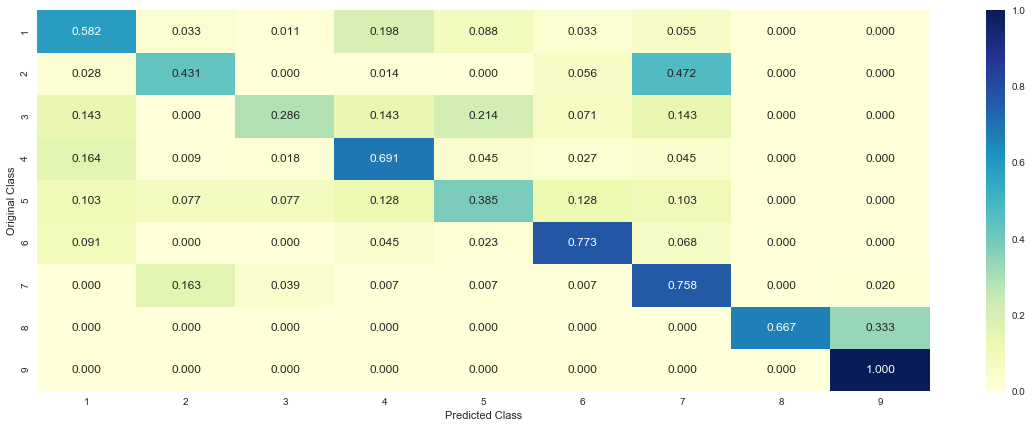

In [94]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

<h3>5.3.3. Feature Importance</h3>

<h4>5.3.3.1. For Correctly classified point</h4>

In [99]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 300
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.834  0.0645 0.0074 0.0302 0.0209 0.0126 0.0238 0.0042 0.0024]]
Actual Class : 1
--------------------------------------------------
31 Text feature [archaebacterial] present in test data point [True]
38 Text feature [nunc] present in test data point [True]
167 Text feature [aggregated] present in test data point [True]
172 Text feature [deficient] present in test data point [True]
206 Text feature [attr] present in test data point [True]
212 Text feature [fluidigm] present in test data point [True]
215 Text feature [ner] present in test data point [True]
260 Text feature [haploinsufficient] present in test data point [True]
265 Text feature [ercc2] present in test data point [True]
269 Text feature [colcemid] present in test data point [True]
287 Text feature [contest] present in test data point [True]
301 Text feature [microsatellite] present in test data point [True]
315 Text feature [mediate] present in test data point [True]
365

In [106]:
test_point_index = 50
no_feature = 600
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.261  0.047  0.0092 0.2966 0.0301 0.0142 0.3314 0.0077 0.0028]]
Actual Class : 4
--------------------------------------------------
32 Text feature [constitutive] present in test data point [True]
34 Text feature [activated] present in test data point [True]
56 Text feature [activation] present in test data point [True]
57 Text feature [expressing] present in test data point [True]
76 Text feature [instruments] present in test data point [True]
97 Text feature [nf] present in test data point [True]
105 Text feature [oncogene] present in test data point [True]
111 Text feature [activate] present in test data point [True]
112 Text feature [transformation] present in test data point [True]
133 Text feature [activating] present in test data point [True]
155 Text feature [downstream] present in test data point [True]
158 Text feature [serum] present in test data point [True]
187 Text feature [transformed] present in test data point [True

<h2>5.5 Random Forest Classifier</h2>

<h3>5.5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [107]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2176182532636342
for n_estimators = 100 and max depth =  10
Log Loss : 1.15228519032339
for n_estimators = 200 and max depth =  5
Log Loss : 1.1970024112107158
for n_estimators = 200 and max depth =  10
Log Loss : 1.1410891972513473
for n_estimators = 500 and max depth =  5
Log Loss : 1.1833474532330217
for n_estimators = 500 and max depth =  10
Log Loss : 1.1337140093794404
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1880192329789174
for n_estimators = 1000 and max depth =  10
Log Loss : 1.128915153116355
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1890340447316057
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1274082800675007
For values of best estimator =  2000 The train log loss is: 0.6423370136589692
For values of best estimator =  2000 The cross validation log loss is: 1.1274082800675007
For values of best estimator =  2000 The test log loss is: 1.1372811368672848


<h3>5.5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

Log loss : 1.1274082800675007
Number of mis-classified points : 0.37969924812030076
-------------------- Confusion matrix --------------------


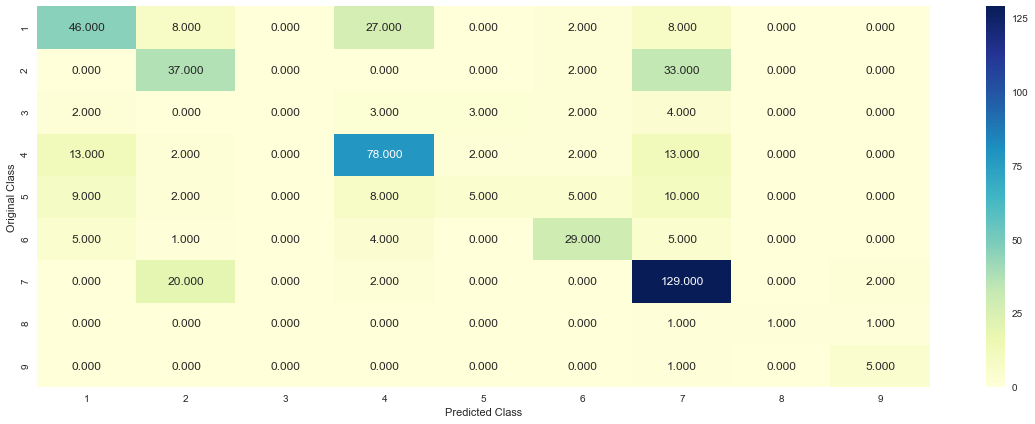

-------------------- Precision matrix (Columm Sum=1) --------------------


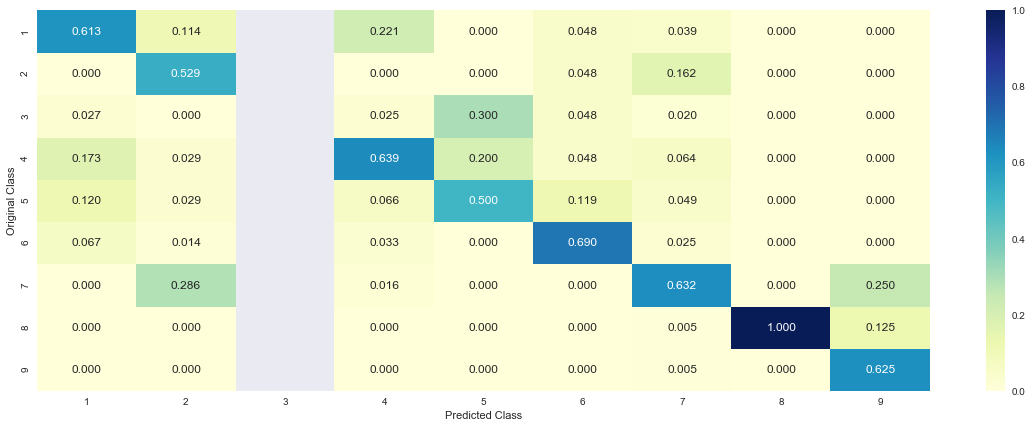

-------------------- Recall matrix (Row sum=1) --------------------


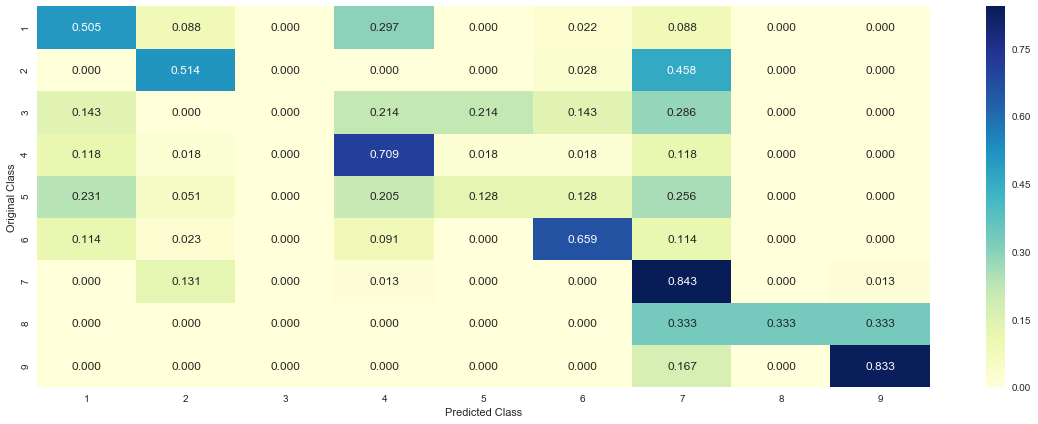

In [109]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [113]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1262 0.2376 0.0236 0.114  0.0608 0.0588 0.363  0.0074 0.0087]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [inhibitors] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [inhibitor] present in test data point [True]
5 Text feature [activated] present in test data point [True]
8 Text feature [growth] present in test data point [True]
9 Text feature [function] present in test data point [True]
10 Text feature [oncogenic] present in test data point [True]
11 Text feature [treatment] present in test data point [True]
15 Text feature [signaling] present in test data point [True]
17 Text feature [proliferation] present in test data point [True]
22 Text feature [inhibition] present in test data point [True]
24 Text feature

In [112]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2198 0.1314 0.0227 0.2082 0.0669 0.0609 0.2749 0.0077 0.0076]]
Actuall Class : 4
--------------------------------------------------
1 Text feature [activating] present in test data point [True]
3 Text feature [activation] present in test data point [True]
5 Text feature [activated] present in test data point [True]
7 Text feature [phosphorylation] present in test data point [True]
8 Text feature [growth] present in test data point [True]
9 Text feature [function] present in test data point [True]
11 Text feature [treatment] present in test data point [True]
12 Text feature [suppressor] present in test data point [True]
13 Text feature [constitutive] present in test data point [True]
16 Text feature [downstream] present in test data point [True]
17 Text feature [proliferation] present in test data point [True]
21 Text feature [loss] present in test data point [True]
22 Text feature [inhibition] present in test data point [True]
23 T

345 Text feature [10] present in test data point [True]
348 Text feature [multiple] present in test data point [True]
349 Text feature [novel] present in test data point [True]
350 Text feature [mutated] present in test data point [True]
351 Text feature [data] present in test data point [True]
352 Text feature [deletion] present in test data point [True]
356 Text feature [harbored] present in test data point [True]
359 Text feature [previously] present in test data point [True]
360 Text feature [controls] present in test data point [True]
362 Text feature [promote] present in test data point [True]
363 Text feature [domain] present in test data point [True]
364 Text feature [cultured] present in test data point [True]
365 Text feature [17] present in test data point [True]
366 Text feature [transcription] present in test data point [True]
367 Text feature [transformed] present in test data point [True]
369 Text feature [2b] present in test data point [True]
371 Text feature [structure

<h3>5.5.3. Hyper paramter tuning (With Response Coding)</h3>

In [114]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1540002017300885
for n_estimators = 10 and max depth =  3
Log Loss : 1.6510281345184288
for n_estimators = 10 and max depth =  5
Log Loss : 1.50527012697872
for n_estimators = 10 and max depth =  10
Log Loss : 1.733379866291421
for n_estimators = 50 and max depth =  2
Log Loss : 1.6903254861838966
for n_estimators = 50 and max depth =  3
Log Loss : 1.4581867830984894
for n_estimators = 50 and max depth =  5
Log Loss : 1.3807896729565015
for n_estimators = 50 and max depth =  10
Log Loss : 1.6950552930239722
for n_estimators = 100 and max depth =  2
Log Loss : 1.549250458559138
for n_estimators = 100 and max depth =  3
Log Loss : 1.4846161783677798
for n_estimators = 100 and max depth =  5
Log Loss : 1.2995857497549852
for n_estimators = 100 and max depth =  10
Log Loss : 1.638703091266004
for n_estimators = 200 and max depth =  2
Log Loss : 1.579514005177445
for n_estimators = 200 and max depth =  3
Log Loss : 1.4820034118432492
for

<h3>5.5.4. Testing model with best hyper parameters (Response Coding)</h3>

Log loss : 1.299585756562591
Number of mis-classified points : 0.4774436090225564
-------------------- Confusion matrix --------------------


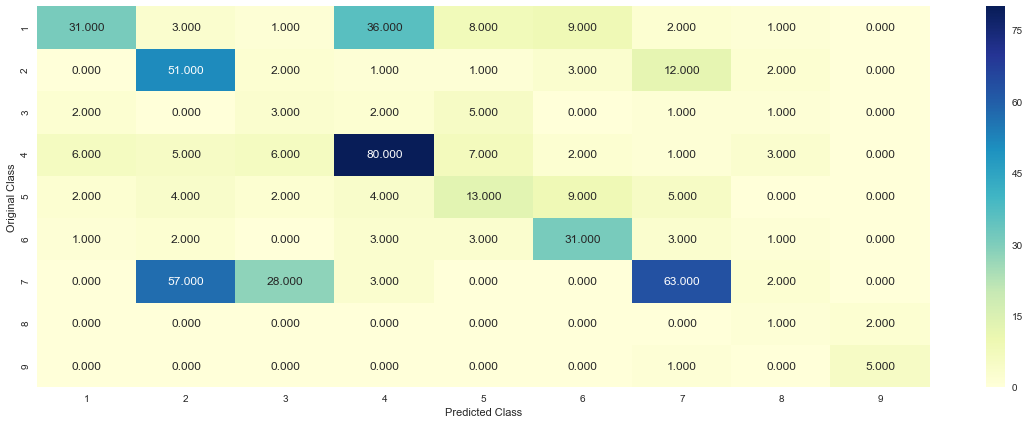

-------------------- Precision matrix (Columm Sum=1) --------------------


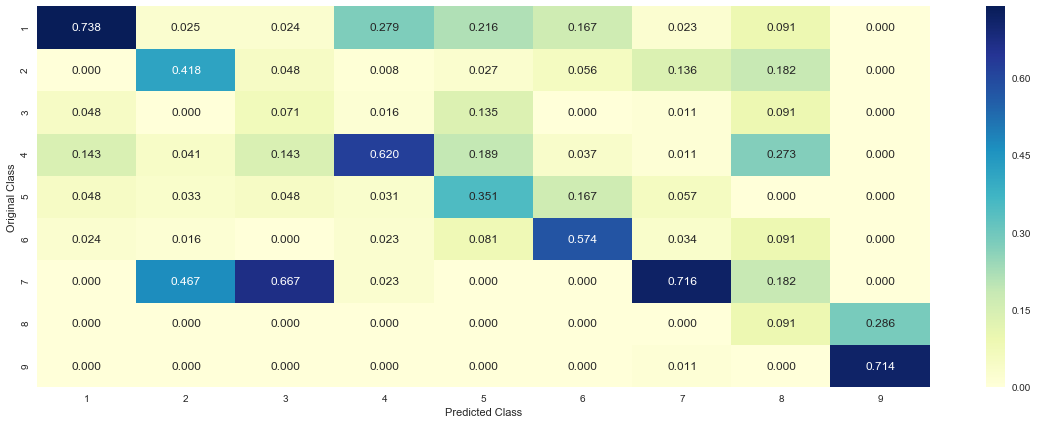

-------------------- Recall matrix (Row sum=1) --------------------


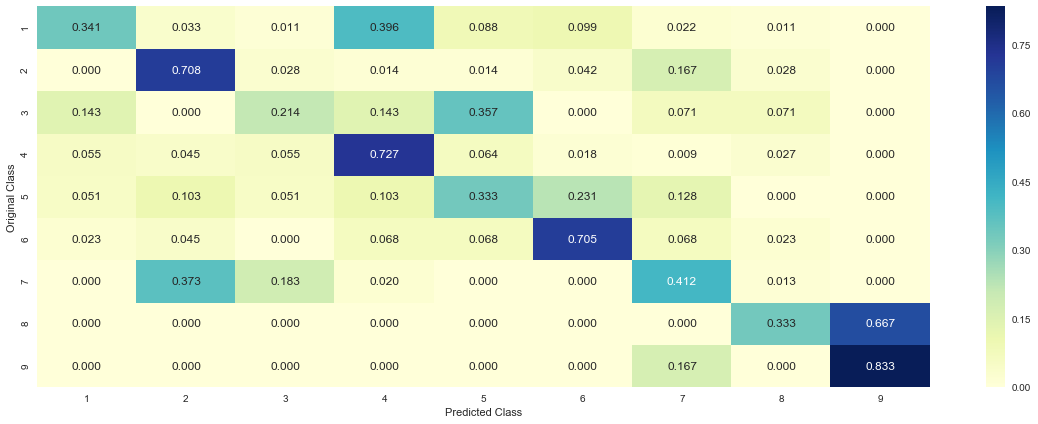

In [115]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [121]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index =100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.2713 0.0643 0.1073 0.0711 0.0595 0.0745 0.0366 0.2246 0.0908]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [122]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0083 0.7464 0.0427 0.0118 0.0141 0.0245 0.1376 0.0081 0.0065]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


<h2>5.7 Stack the models </h2>

In [123]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.05
Support vector machines : Log Loss: 1.45
Naive Bayes : Log Loss: 1.22
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.033
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.490
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.089
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.173
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.422


<h3>5.7.2 testing the model with the best hyper parameters</h3>

Log loss (train) on the stacking classifier : 0.6415543598684148
Log loss (CV) on the stacking classifier : 1.0894763724935723
Log loss (test) on the stacking classifier : 1.1157362855554778
Number of missclassified point : 0.36390977443609024
-------------------- Confusion matrix --------------------


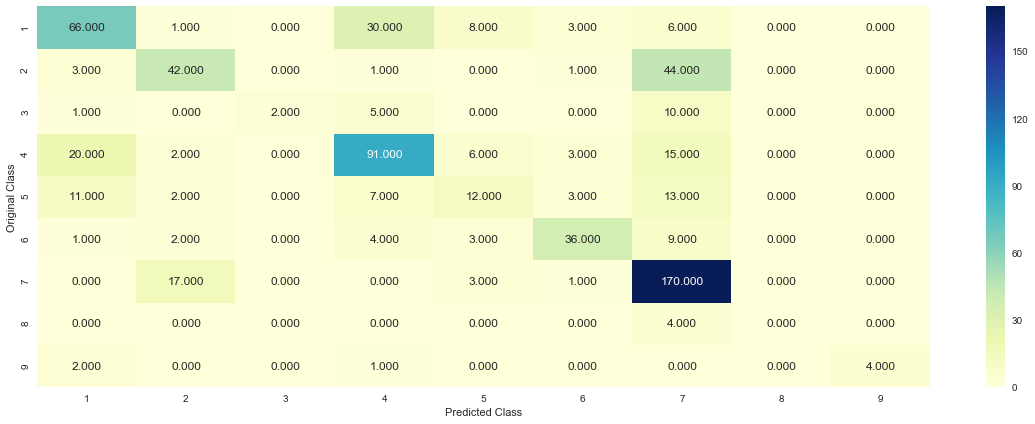

-------------------- Precision matrix (Columm Sum=1) --------------------


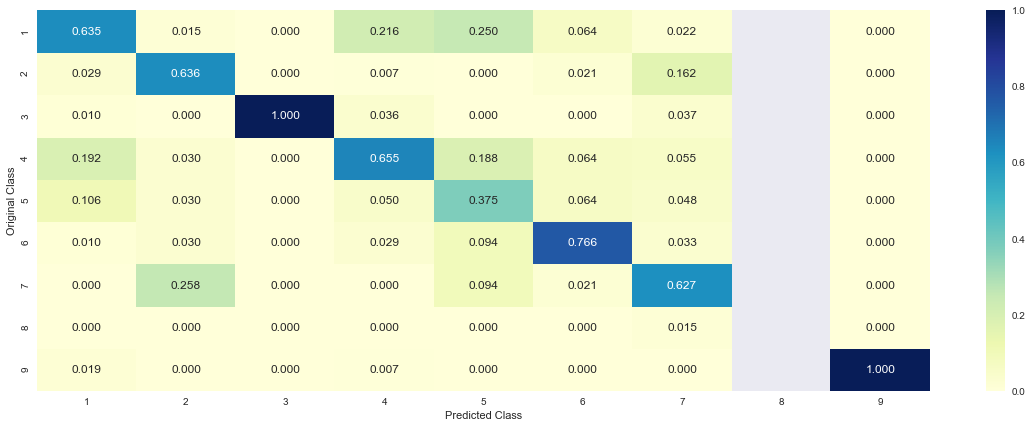

-------------------- Recall matrix (Row sum=1) --------------------


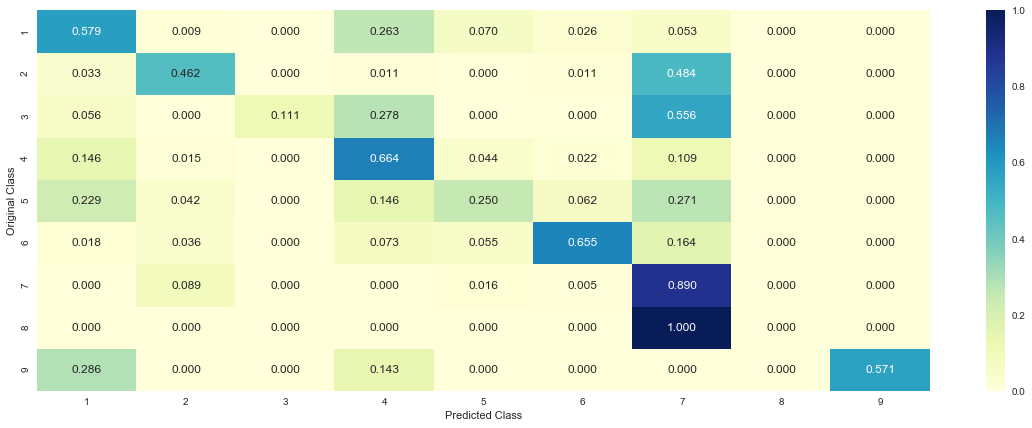

In [124]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>5.7.3 Maximum Voting classifier </h3>

Log loss (train) on the VotingClassifier : 0.8640471828928525
Log loss (CV) on the VotingClassifier : 1.1061594890166055
Log loss (test) on the VotingClassifier : 1.1376940916349263
Number of missclassified point : 0.3593984962406015
-------------------- Confusion matrix --------------------


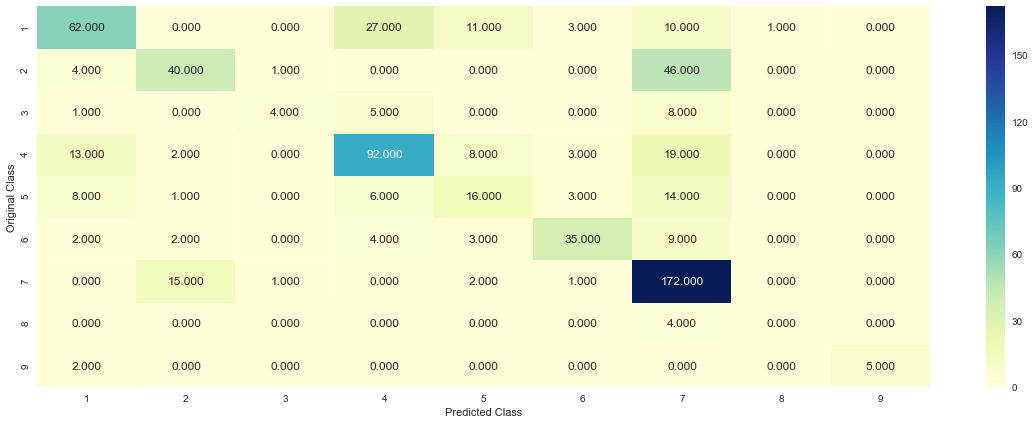

-------------------- Precision matrix (Columm Sum=1) --------------------


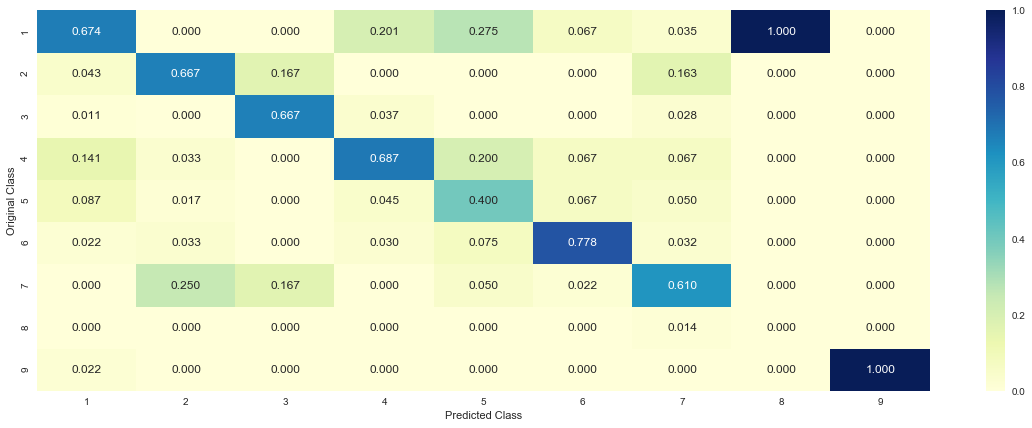

-------------------- Recall matrix (Row sum=1) --------------------


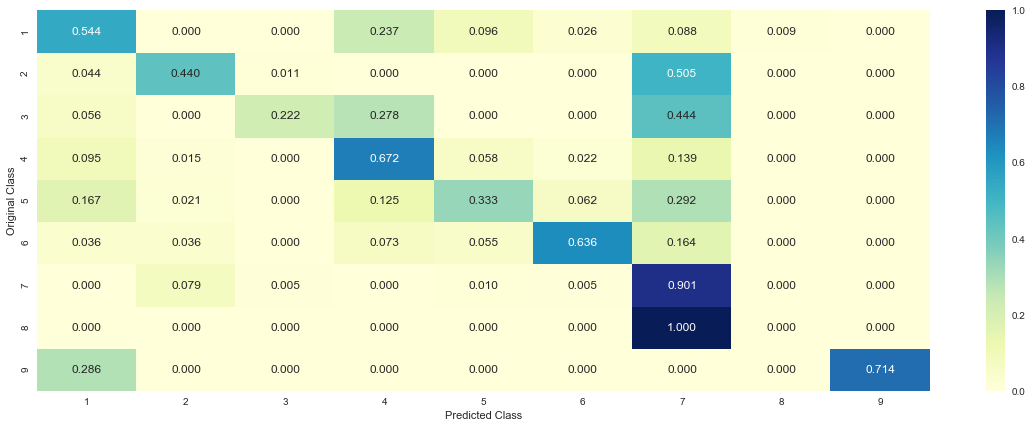

In [125]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# Result by Applying All the Models with Tfidf

In [130]:
data={'Train Loss':[0.9379,0.6341,0.5759,0.5652,0.6920,0.6423,0.0544,0.8890],'CV Loss':[1.2086,0.9981,1.0487,1.076,1.115,1.127,1.2603,1.124],
      'Test Loss':[1.177,1.051,1.0532,1.074,1.0734,1.137,1.3486,1.1707],'MissClassified points':[0.4135,0.35150,0.3627,0.3627,0.3665,0.3590,0.4417,0.3864]}
pd.DataFrame(data,index=['Naive Bayes(OHE)','KNN(Response Coding)','Logistic Regression(OHE)','Logistic Regression(Without Class Balancing)','SVM(OHE)','RFC(OHE)','RFC(Respose Coding)','Maximum Voting Classifier'])

Train Loss  CV Loss  Test Loss  \
Naive Bayes(OHE)                                  0.9379   1.2086     1.1770   
KNN(Response Coding)                              0.6341   0.9981     1.0510   
Logistic Regression(OHE)                          0.5759   1.0487     1.0532   
Logistic Regression(Without Class Balancing)      0.5652   1.0760     1.0740   
SVM(OHE)                                          0.6920   1.1150     1.0734   
RFC(OHE)                                          0.6423   1.1270     1.1370   
RFC(Respose Coding)                               0.0544   1.2603     1.3486   
Maximum Voting Classifier                         0.8890   1.1240     1.1707   

                                              MissClassified points  
Naive Bayes(OHE)                                             0.4135  
KNN(Response Coding)                                         0.3515  
Logistic Regression(OHE)                                     0.3627  
Logistic Regression(Without Class Balancing)                 0.3627  
SVM(OHE)                                                     0.3665  
RFC(OHE)                                                     0.3590  
RFC(Respose Coding)                                          0.4417  
Maximum Voting Classifier                                    0.3864

# Results by Applying only 1000 features 

In [131]:
data={'Train Loss':[0.5331,0.6411,0.4499,0.4429,0.6920,0.6423,0.0544,0.864],'CV Loss':[1.120,0.9561,0.9228,0.9472,1.115,1.127,1.299,1.106],
      'Test Loss':[1.196,1.0499,1.024,1.039,1.0734,1.137,1.257,1.137],'MissClassified points':[0.3364,0.3308,0.3233,0.4736,0.3665,0.3796,0.4774,0.3593]}
pd.DataFrame(data,index=['Naive Bayes(OHE)','KNN(Response Coding)','Logistic Regression(OHE)','Logistic Regression(Without Class Balancing)','SVM(OHE)','RFC(OHE)','RFC(Respose Coding)','Maximum Voting Classifier'])

Train Loss  CV Loss  Test Loss  \
Naive Bayes(OHE)                                  0.5331   1.1200     1.1960   
KNN(Response Coding)                              0.6411   0.9561     1.0499   
Logistic Regression(OHE)                          0.4499   0.9228     1.0240   
Logistic Regression(Without Class Balancing)      0.4429   0.9472     1.0390   
SVM(OHE)                                          0.6920   1.1150     1.0734   
RFC(OHE)                                          0.6423   1.1270     1.1370   
RFC(Respose Coding)                               0.0544   1.2990     1.2570   
Maximum Voting Classifier                         0.8640   1.1060     1.1370   

                                              MissClassified points  
Naive Bayes(OHE)                                             0.3364  
KNN(Response Coding)                                         0.3308  
Logistic Regression(OHE)                                     0.3233  
Logistic Regression(Without Class Balancing)                 0.4736  
SVM(OHE)                                                     0.3665  
RFC(OHE)                                                     0.3796  
RFC(Respose Coding)                                          0.4774  
Maximum Voting Classifier                                    0.3593